In [1]:
from __future__ import absolute_import
import os
from tqdm import tqdm
import torch
torch.multiprocessing.set_sharing_strategy('file_system')
import torch.nn.functional as F
import utils.utility as utility
from utils.logger import Logger
from torchvision.models import resnet18
from data.Camelyon import Camelyon
import argparse
from importlib import import_module
from utils.utility import adjust_learning_rate
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

    

from torch.utils.data import DataLoader
import numpy as np

##epoch #############################ratio 
### log_dir and data_root
def parse_args():
    parser = argparse.ArgumentParser(description='317 MIL Framework')
    parser.add_argument("--task", type=str, default="Digest",
                        help="Which task to perform",
                        choices=["Digest", "Camelyon"])
    parser.add_argument('--config', type=str, default='DigestSegPB',
                        help="Config file to use.",
                        choices=["DigestSegEMCAV2", "DigestSeg", 'DigestSegPB',
                                 'DigestSegTOPK', 'DigestSegFull','DigestSegRCE'])
    parser.add_argument("--log_dir", type=str,
                        default="/home/ltc/1T/Experiment/move/Baseline/f1",
                        help="The experiment log directory")
    parser.add_argument("--data_root", "-d", type=str,
                        default="/home/ltc/Phase2/5_folder/1",
                        help="root directory of data used")
    parser.add_argument("--resume", type=int, default=-1, help="Resume epoch")

    parser.add_argument("--backbone", type=str, default='res18',
                        help="which backbone to use.")
    parser.add_argument("--pretrained", action="store_true", default=False,
                        help="Whether to use weighted BCE loss")

    parser.add_argument('-lr', type=float, default=1e-3, help="Learning rate")
    parser.add_argument("--epochs", "-e", type=int, default=50,
                        help="How many epochs to train")
    parser.add_argument('--cos', action='store_true', default=True,
                      help='use cosine lr schedule')
    parser.add_argument('--schedule', default=[120, 160], nargs='*', type=int,
                        help='learning rate schedule (when to drop lr by 10x)')
    #choose loss
    # parser.add_argument("--rce", action="store_true", default=False, help="Whether to use weighted BCE loss")
    #Calibration loss
    parser.add_argument("--stop_epoch", type=int, default=-1, help="stop")
    parser.add_argument("--ignore_thres", type=float, default=0.95, help="ignore")
    #one-stage or two stage training
    parser.add_argument("--database", action="store_true", default=False, help="Using database")
    parser.add_argument('--workers', default=8, type=int, metavar='N',
                        help='number of data loading workers (default: 32)')
    parser.add_argument("--load", type=int, default=-1, help="the epoch to be loaded")
    parser.add_argument("--load_path", type=str,
                        default="/home/tclin/1T/Experiment/move/Baseline/f3",
                        help="The load directory")
    #EM
    parser.add_argument("--mmt", type=float, default=0.9, help="mmt")
    parser.add_argument("--noisy", action="store_true", default=False, help="Noisy bag pos ratio")

    # ssl
    parser.add_argument("--ssl", action="store_true", default=False, help="Self supervised learning")
    parser.add_argument("--camelyon", action="store_true", default=False, help="Training on camelyon")
    parser.add_argument("--pickle", action="store_true", default=False, help="Using pickle")
    args = parser.parse_args(['-lr', '1e-3'])
    return args


##epoch #############################ratio 
### log_dir and data_root

def eval_(self, gs, trainset):
    # self.backbone = self.logger.load_backbone_fromold(self.backbone, global_step=gs)
    # self.clsnet = self.logger.load_clsnet_fromold(self.clsnet, global_step=gs)
    self.backbone = self.logger.load_backbone(self.backbone, global_step=gs)
    self.clsnet = self.logger.load_clsnet(self.clsnet, global_step=gs)
    self.backbone.eval()
    self.clsnet.eval()
    val_loader = DataLoader(trainset, 256, shuffle=True, num_workers=4)
    preds_list = []
    bag_index_list = []
    label_list = []
    idx_x_list = []
    idx_y_list = []
    path_list = []
    with torch.no_grad():
        for batch_idx, (imgs, instance_labels, bag_index, inner_index, nodule_ratios, real_ins_labels) in enumerate(
                tqdm(val_loader, ascii=True, ncols=60)):
            instance_preds = torch.sigmoid(self.clsnet(self.backbone(imgs.to(self.device))))
            # instance_labels = instance_labels.to(self.device)
            preds_list.append(instance_preds)
            bag_index_list.append(bag_index)
            label_list.append(real_ins_labels)
            idx_x_list.append(inner_index[1])
            idx_y_list.append(inner_index[2])
            path_list.extend(list(inner_index[3]))

#             if batch_idx >10:
#                 break
            
    return preds_list, bag_index_list, label_list, idx_x_list, idx_y_list, path_list

 #############################ratio 
### log_dir ## data_root ##epoch
args = parse_args()
if args.task == 'Digest':
    configs = getattr(import_module('configs.'+'DigestSeg'), 'Config')(args)
elif args.task == 'Camelyon':
    configs = getattr(import_module('configs.' + 'Camelyon'), 'Config')(args)
else:
    raise NotImplementedError
configs.logger.init_backup(configs)
trainer = configs.trainer
tester = configs.tester
trainer.eval = eval_
epoch=50

  




log_dir                        /home/ltc/1T/Experiment/move/Baseline/f1

resume                         -1

data_root                      /home/ltc/Phase2/5_folder/1

train_transform_C              Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.2, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ColorJitter(brightness=[0.75, 1.25], contrast=[0.75, 1.25], saturation=[0.75, 1.25], hue=[-0.25, 0.25])
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

test_transform_C               Compose(
    Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

batch_size                     64

backbone                       ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [2]:
preds_list, bag_index_list, label_list, idx_x_list, idx_y_list, path_list=trainer.eval(trainer, epoch, configs.testset)


==> Resuming net of epoch /home/ltc/1T/Experiment/move/Baseline/f1/ckp/net.ckpt50.pth


  0%|                                | 0/28 [00:00<?, ?it/s]

set()
==> Resuming net of epoch /home/ltc/1T/Experiment/move/Baseline/f1/ckp/net.ckpt50.pth
set()


100%|#######################| 28/28 [00:33<00:00,  1.39it/s]


In [3]:
trainset=configs.testset
preds_tensor = torch.cat(preds_list)
bag_index_tensor = torch.cat(bag_index_list)
labels_tensor = torch.cat(label_list)
bag_pos_ratio = torch.stack(trainset.bag_pos_ratios)

idx_x_tensor = torch.cat(idx_x_list)
idx_y_tensor = torch.cat(idx_y_list)

#threshold
t_neg_preds_tensor = preds_tensor.clone().cpu()
t_neg_preds_tensor [t_neg_preds_tensor<0.5]=0
t_preds = (preds_tensor>0.5).float().cpu()
preds_in_list = [t_preds[bag_index_tensor == i] for i in range(bag_index_tensor.max() + 1) if
                         torch.stack(trainset.bag_pos_ratios)[i] != 0]
t_neg_preds_in_list = [t_neg_preds_tensor[bag_index_tensor == i] for i in range(bag_index_tensor.max() + 1) if
                         torch.stack(trainset.bag_pos_ratios)[i] != 0]
bag_labels_in_list = [labels_tensor[bag_index_tensor == i] for i in range(bag_index_tensor.max() + 1) if
                      torch.stack(trainset.bag_pos_ratios)[i] != 0]

path_in_list = [np.array(path_list)[bag_index_tensor == i] for i in range(bag_index_tensor.max() + 1) if
                torch.stack(trainset.bag_pos_ratios)[i] != 0]
selection_acc_in_list = [
    (preds_in_list [i] == bag_labels_in_list[i]).sum().float() / len(preds_in_list[i]) for i in
    range(len(preds_in_list))]
idx_xs = [idx_x_tensor[bag_index_tensor == i] for i in range(bag_index_tensor.max() + 1) if
          torch.stack(trainset.bag_pos_ratios)[i] != 0]
idx_ys = [idx_y_tensor[bag_index_tensor == i] for i in range(bag_index_tensor.max() + 1) if
          torch.stack(trainset.bag_pos_ratios)[i] != 0]
values, indices = torch.topk(torch.stack(selection_acc_in_list), len(selection_acc_in_list))
values, indices

(tensor([110.1707,  96.6119,  83.0000,  76.5333,  57.4923,  53.9481,  52.2759,
          52.0000,  50.4138,  50.0000,  47.8387,  45.2174,  41.2128,  39.3556,
          37.8696,  37.3333,  37.0000,  36.0000,  36.0000,  35.0000,  33.1034,
          32.0000,  30.8519,  29.8571,  29.8235,  29.3158,  28.7241,  27.1905,
          26.8519,  26.3000,  25.8205,  25.5862,  25.0000,  23.2432,  22.0000,
          22.0000,  21.0000,  20.0698,  20.0000,  19.7879,  16.4118,  15.7742,
          15.2000,  14.8824,  12.2857,  11.5111,  10.0667,   9.6667,   7.6000,
           6.2000]),
 tensor([16, 38, 27,  8, 39,  2, 31,  1, 26, 10, 22, 25, 43, 19, 35, 41, 17,  5,
         40, 29,  3, 32,  0, 12, 42, 47, 20, 14,  9, 33, 21, 18, 44, 24, 28, 45,
         48, 23, 49, 37, 11,  4,  7,  6, 15, 34, 36, 13, 46, 30]))

50_0_164_1618-13347B_2019-05-08 01_37_25-lv1-18918-18855-10791-8621


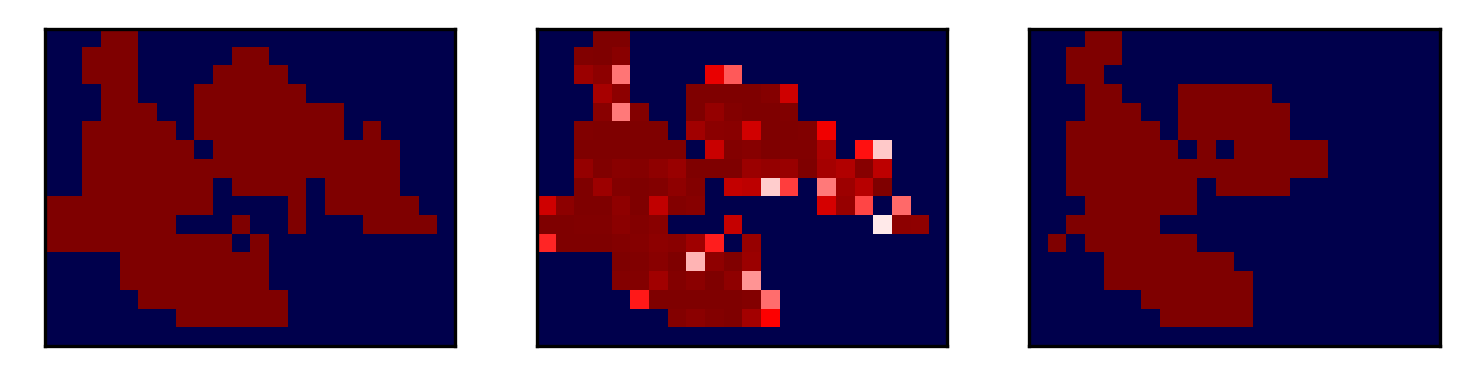

50_1_134_3818-13575B_2019-05-08 01_53_27-lv1-15618-6850-9892-9644


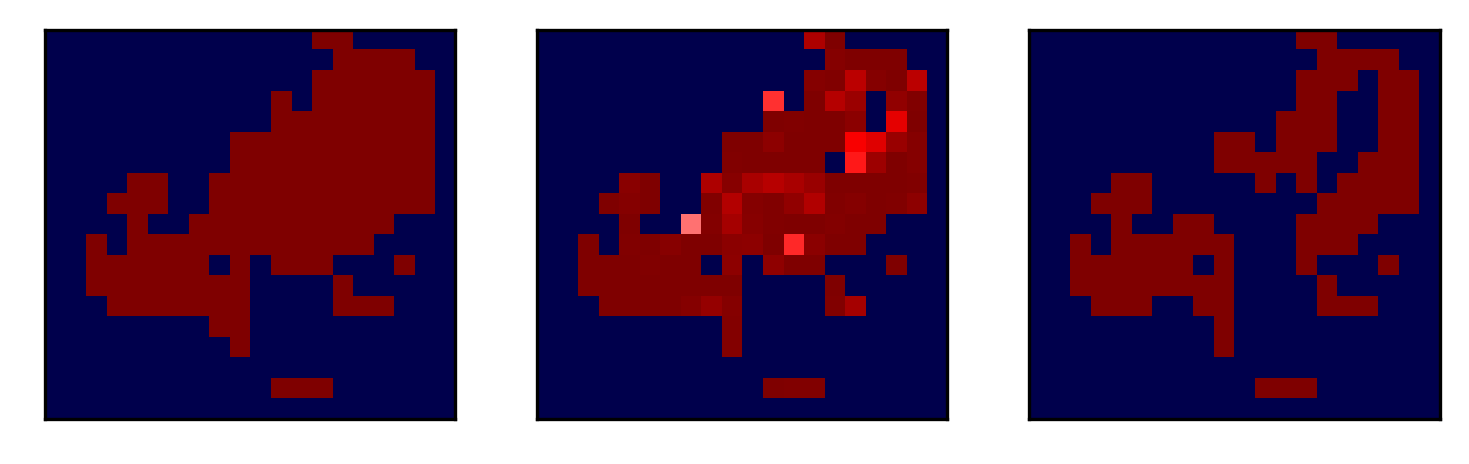

50_2_88_271900838001_2019-04-30 10_15_23-lv1-20231-15672-6703-7495


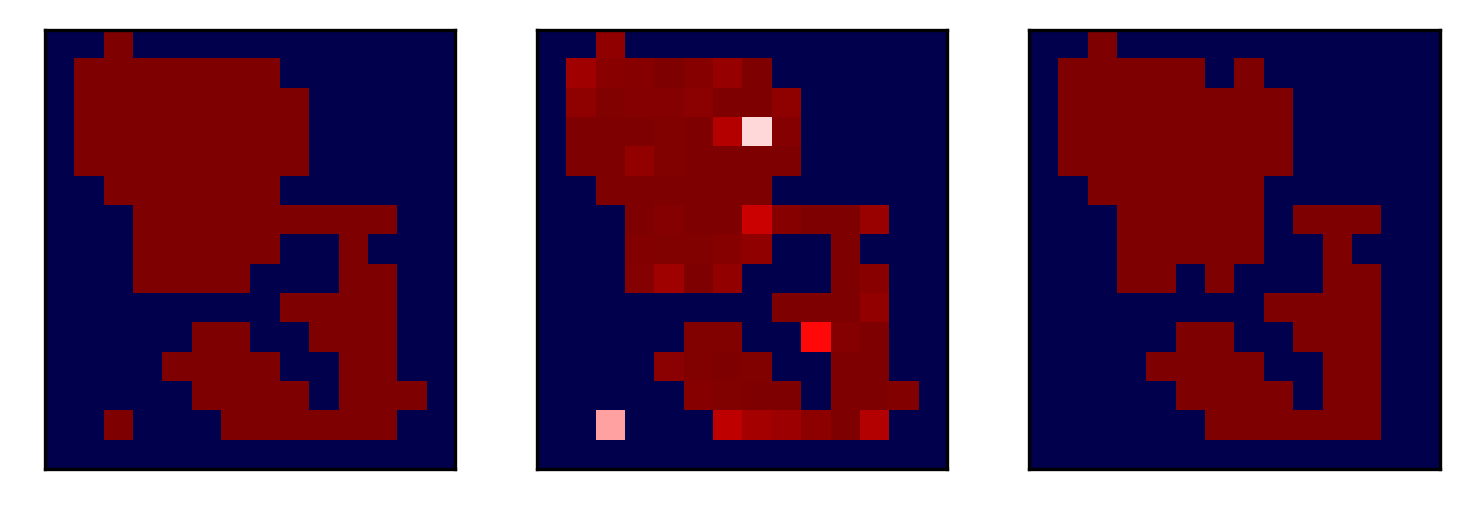

50_3_120_818-16638A_2019-05-08 02_54_25-lv1-21673-13678-6288-8686


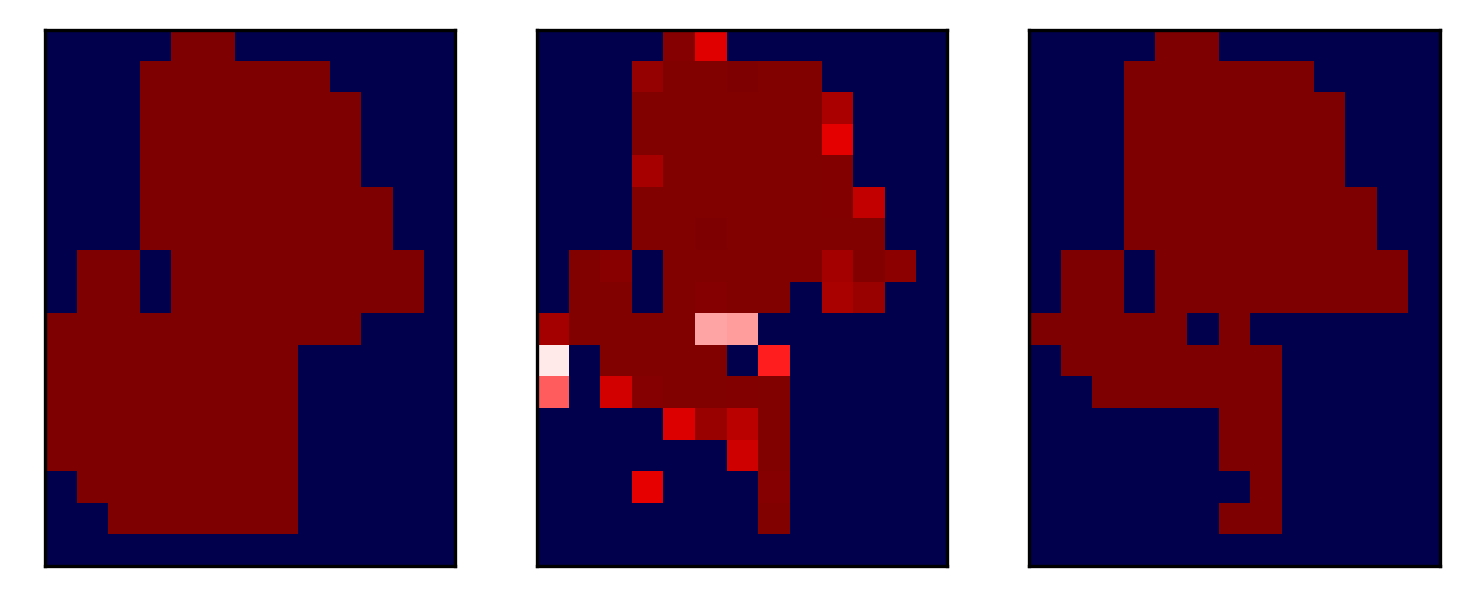

50_4_65_3918-13347A_2019-05-08 01_31_58-lv1-19772-17132-3435-7294


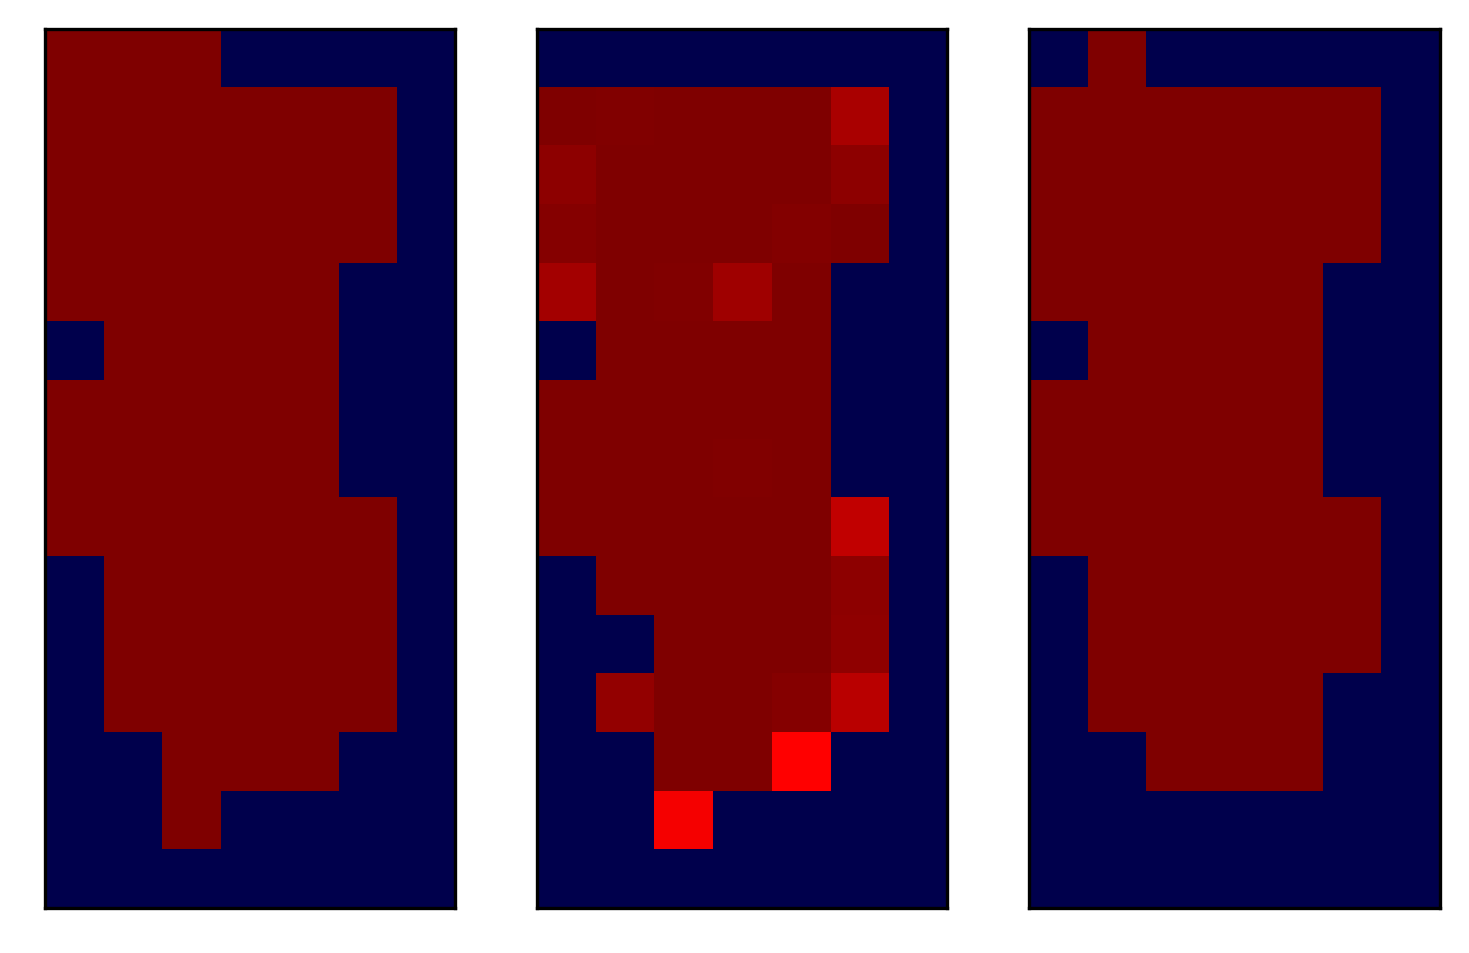

50_5_77_22018_70770_1-1_2019-02-20 23_53_21-lv1-32477-7770-6225-5402


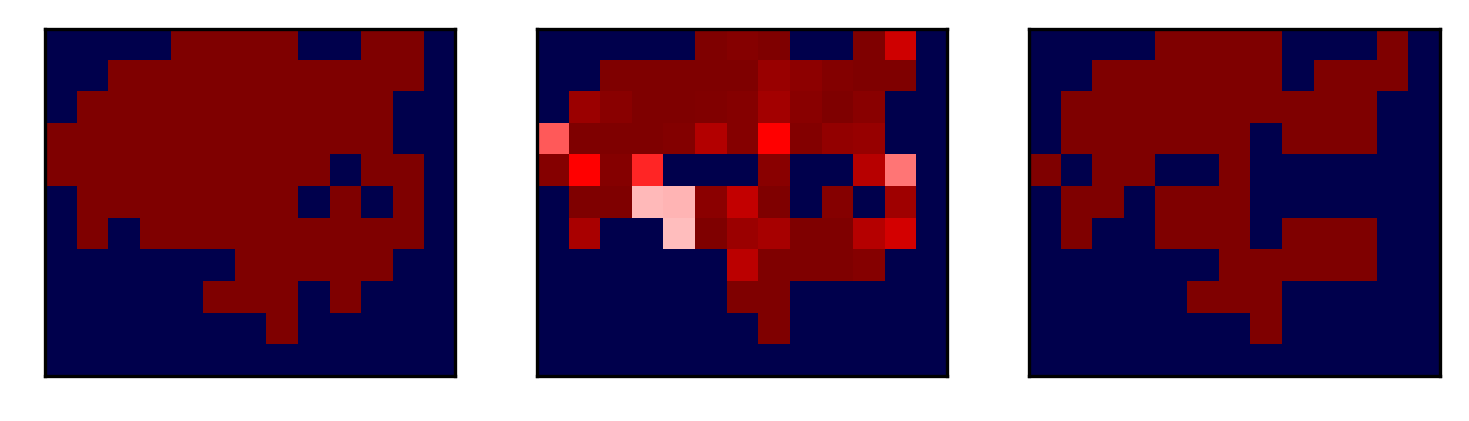

50_6_58_311901558001_2019-04-30 10_24_11-lv1-50393-31270-4213-7808


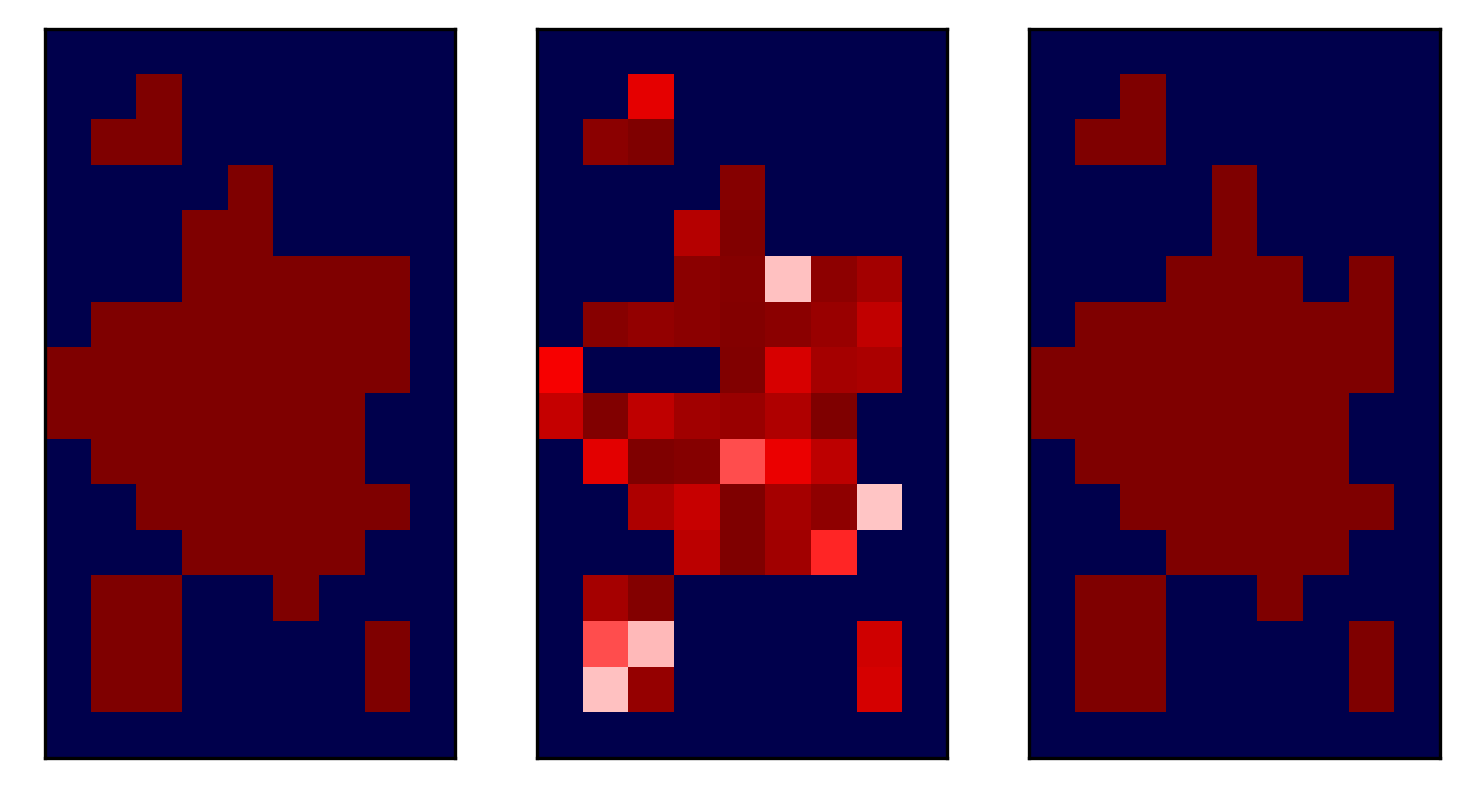

50_7_52_12018_70917_1-1_2019-02-20 23_55_17-lv1-40720-18654-3821-5317


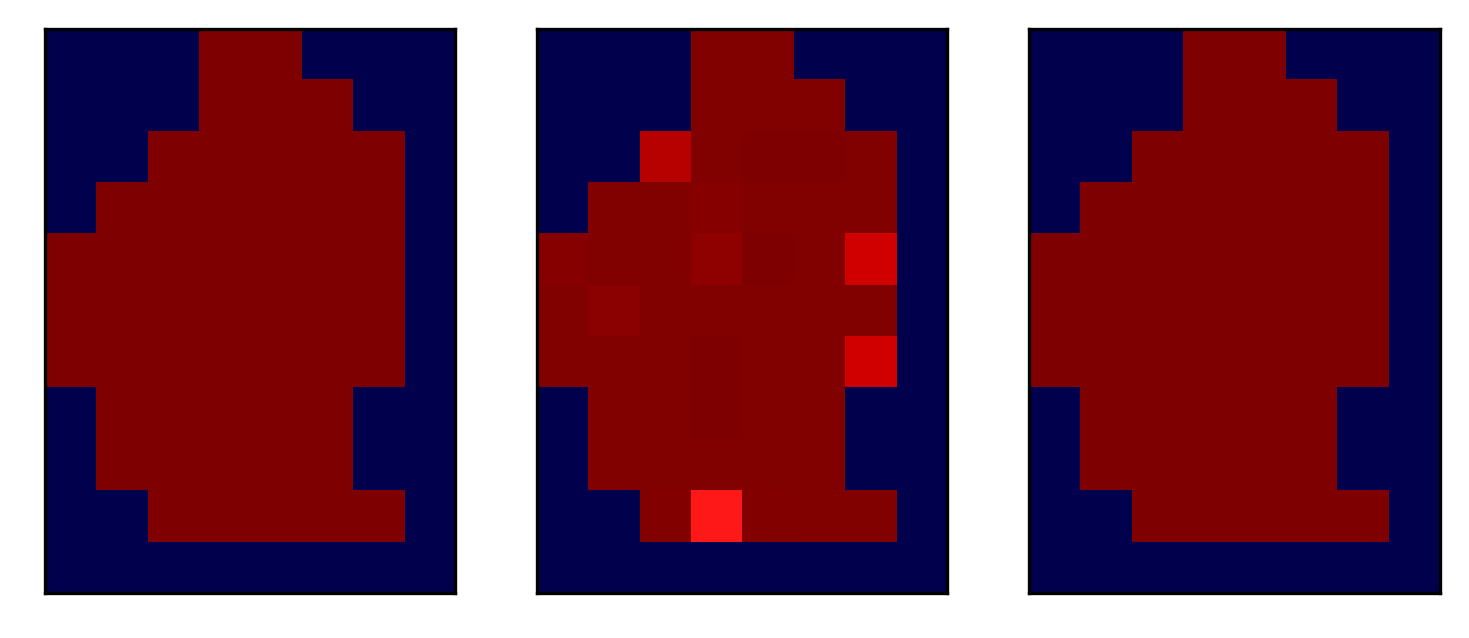

50_8_58_2618-16638B_2019-05-08 02_58_19-lv1-2771-11260-4929-4633


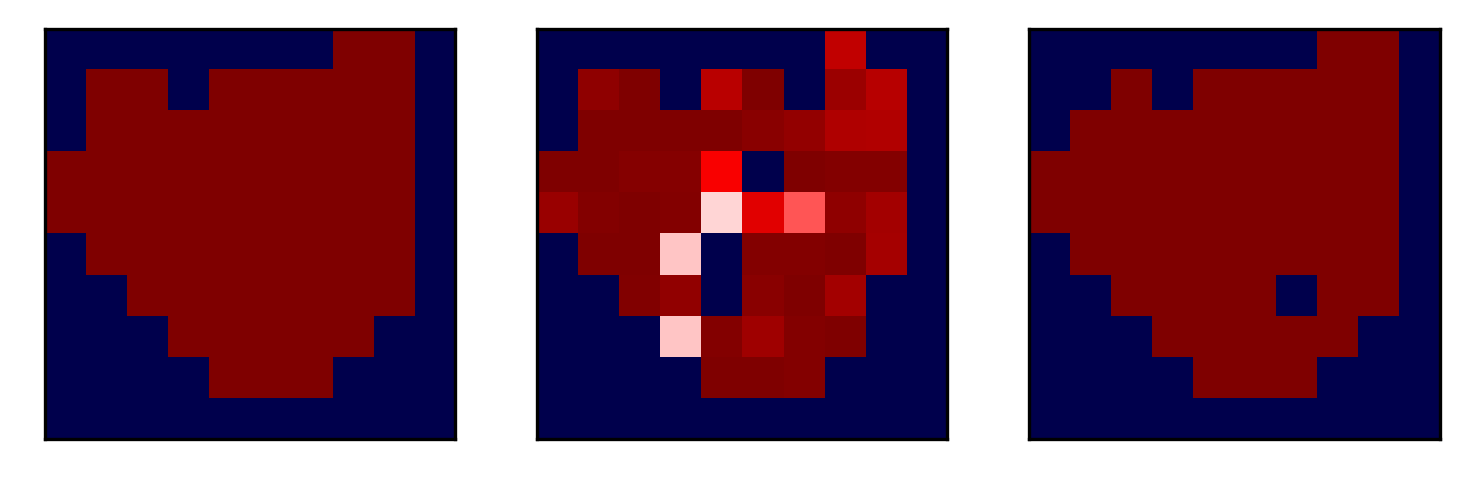

50_9_100_102018_68099_1-1_2019-02-20 23_21_13-lv1-12019-11071-5953-7294


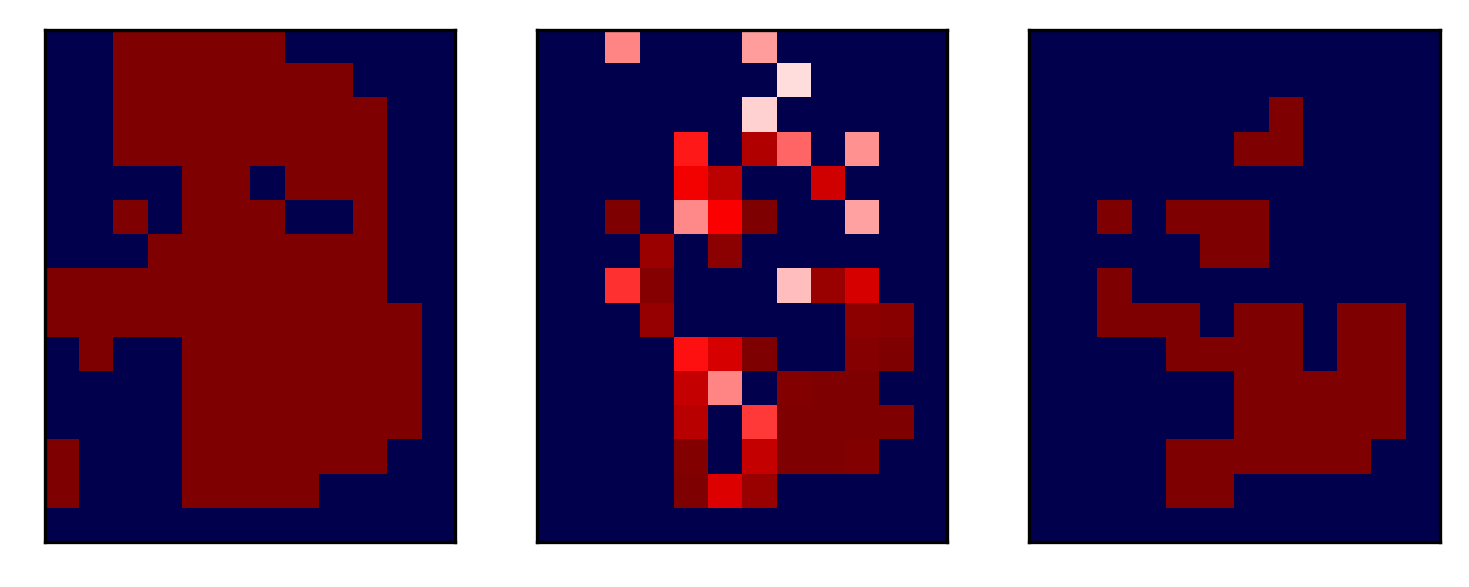

50_10_62_222018_62532_1-1_2019-02-20 21_54_51-lv1-53445-28477-5625-5981


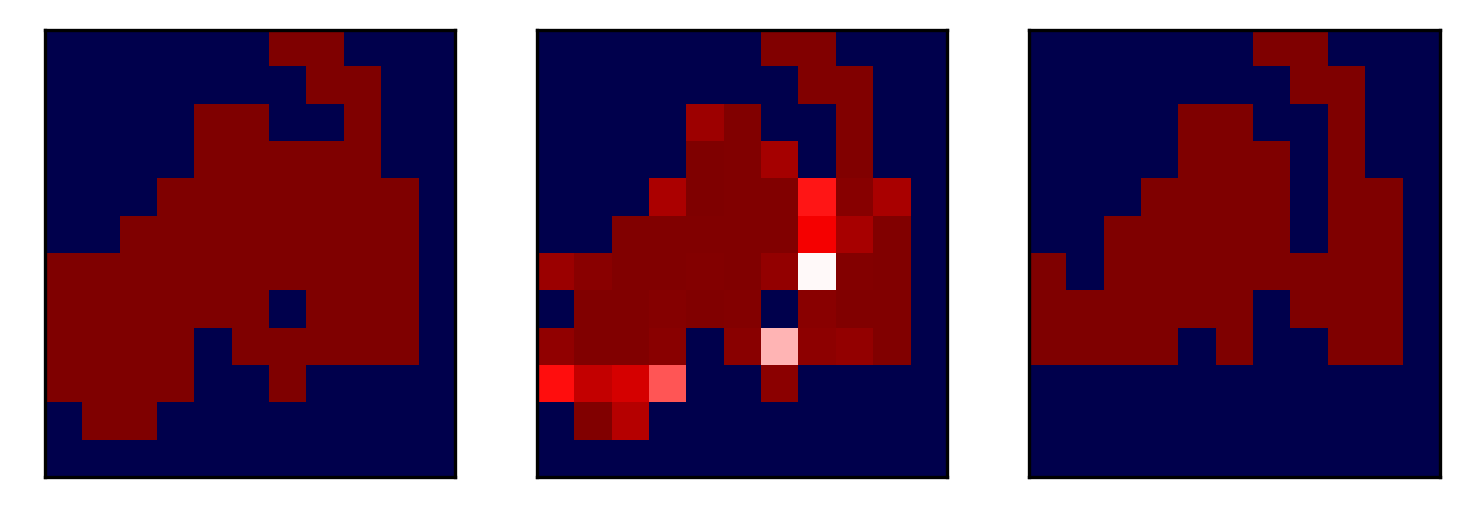

50_11_92_2518-13347A_2019-05-08 01_31_58-lv1-14057-17758-5693-6244


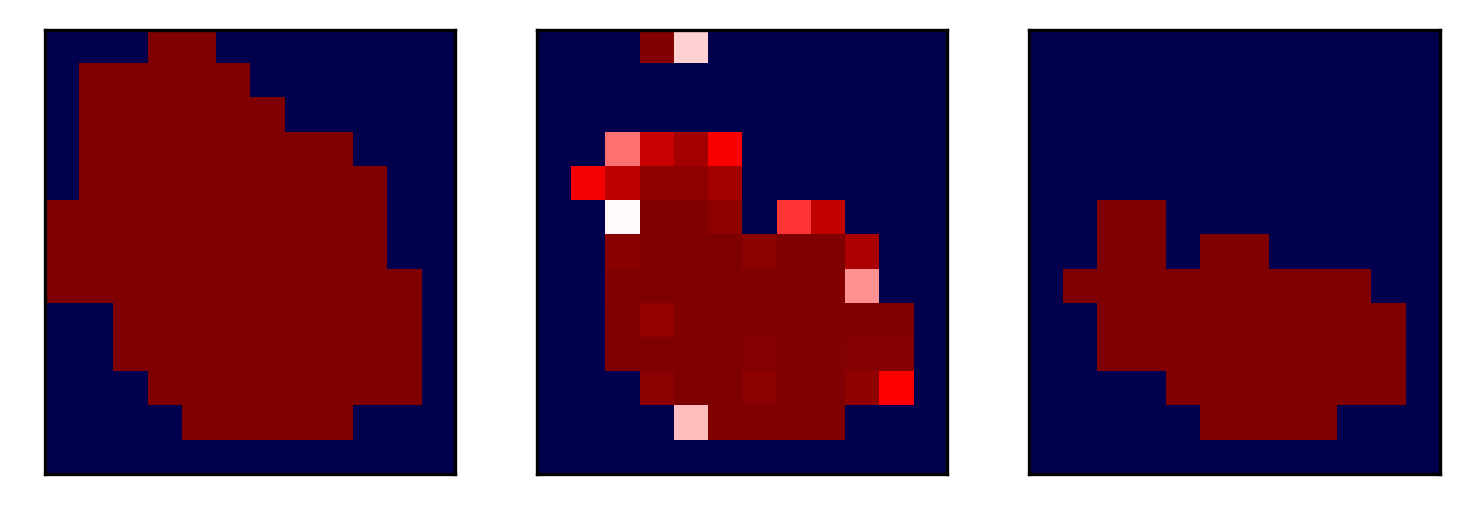

50_12_47_4318-14278A_2019-05-08 02_07_39-lv1-8938-10396-3934-5758


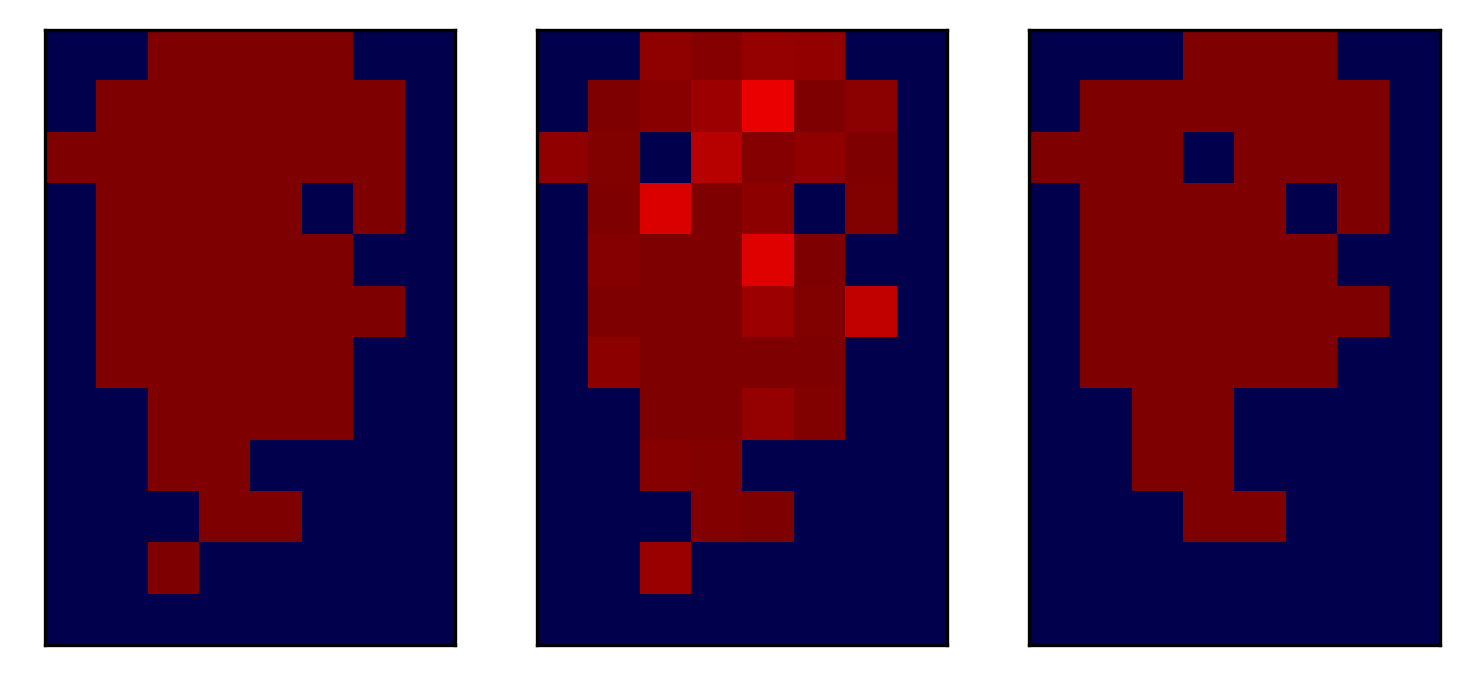

50_13_45_191901940-1_2019-04-30 10_30_47-lv1-40561-17303-4906-4343


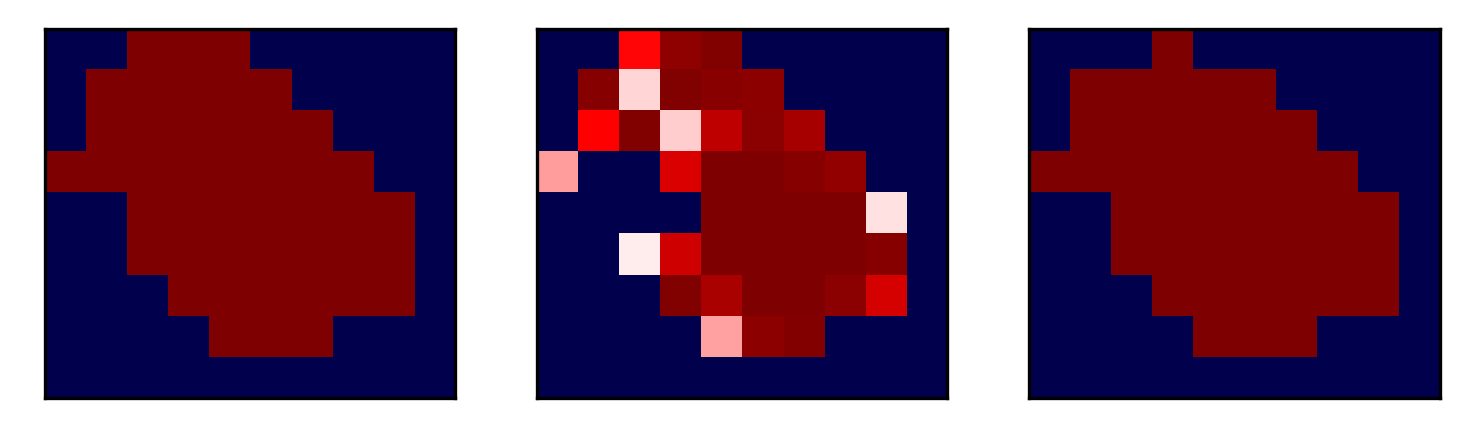

50_14_46_3518-16638B_2019-05-08 02_58_19-lv1-566-16540-4876-3615


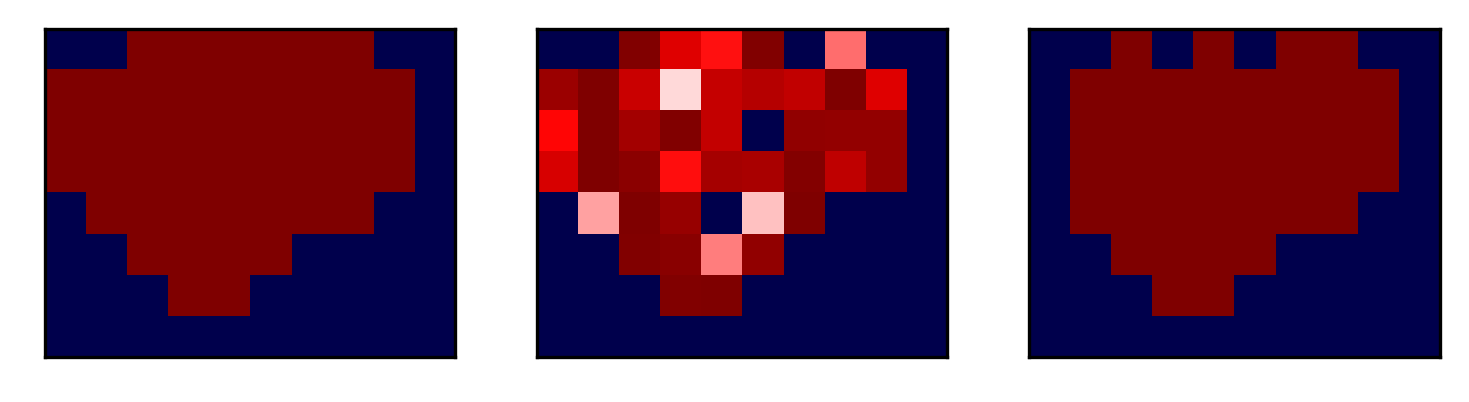

50_15_48_412018_70917_1-1_2019-02-20 23_55_17-lv1-43711-23484-4047-4165


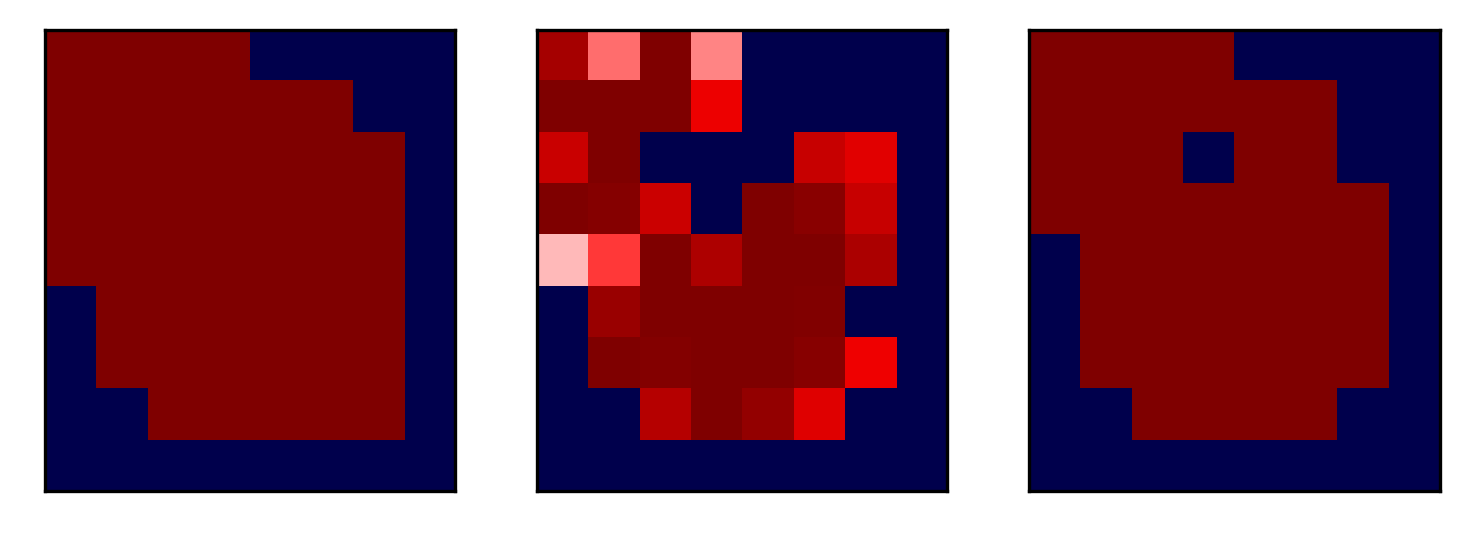

50_16_39_171901940-1_2019-04-30 10_30_47-lv1-44085-11603-3541-4701


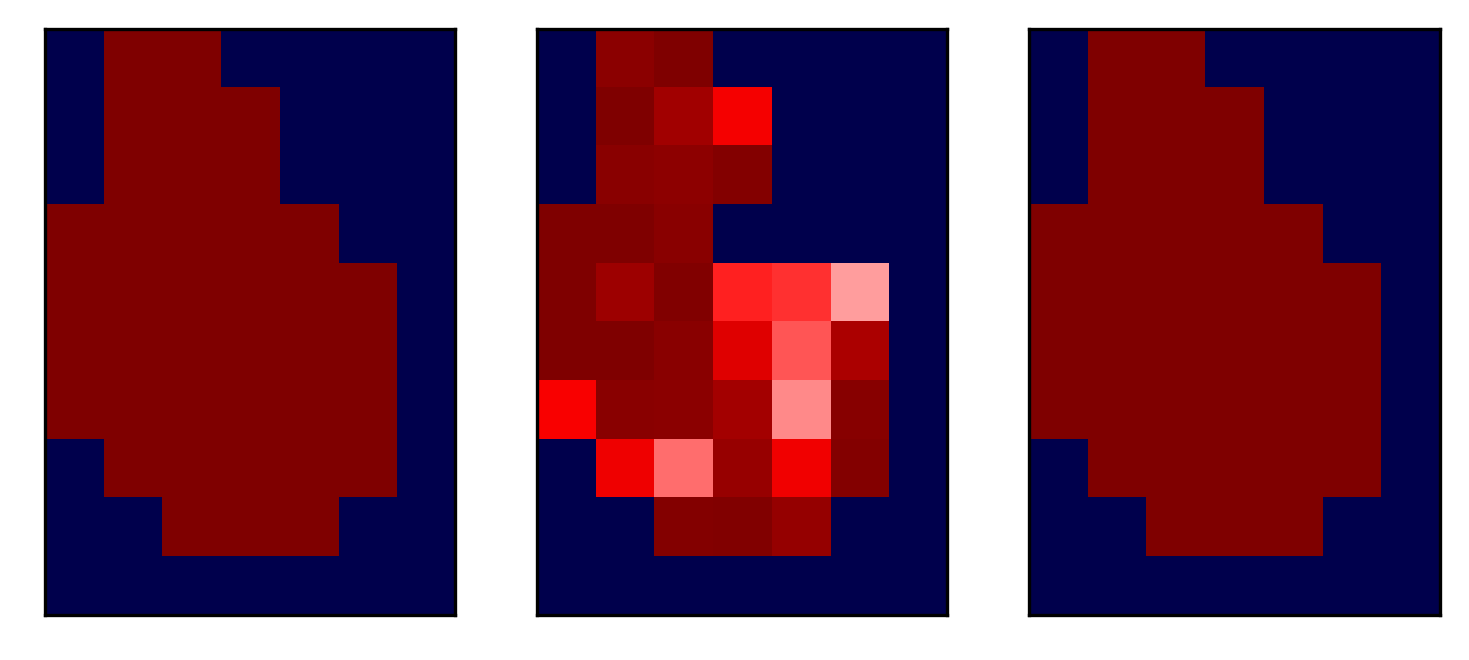

50_17_36_52018_67378_1-1_2019-02-20 22_49_25-lv1-40593-13366-3070-4835


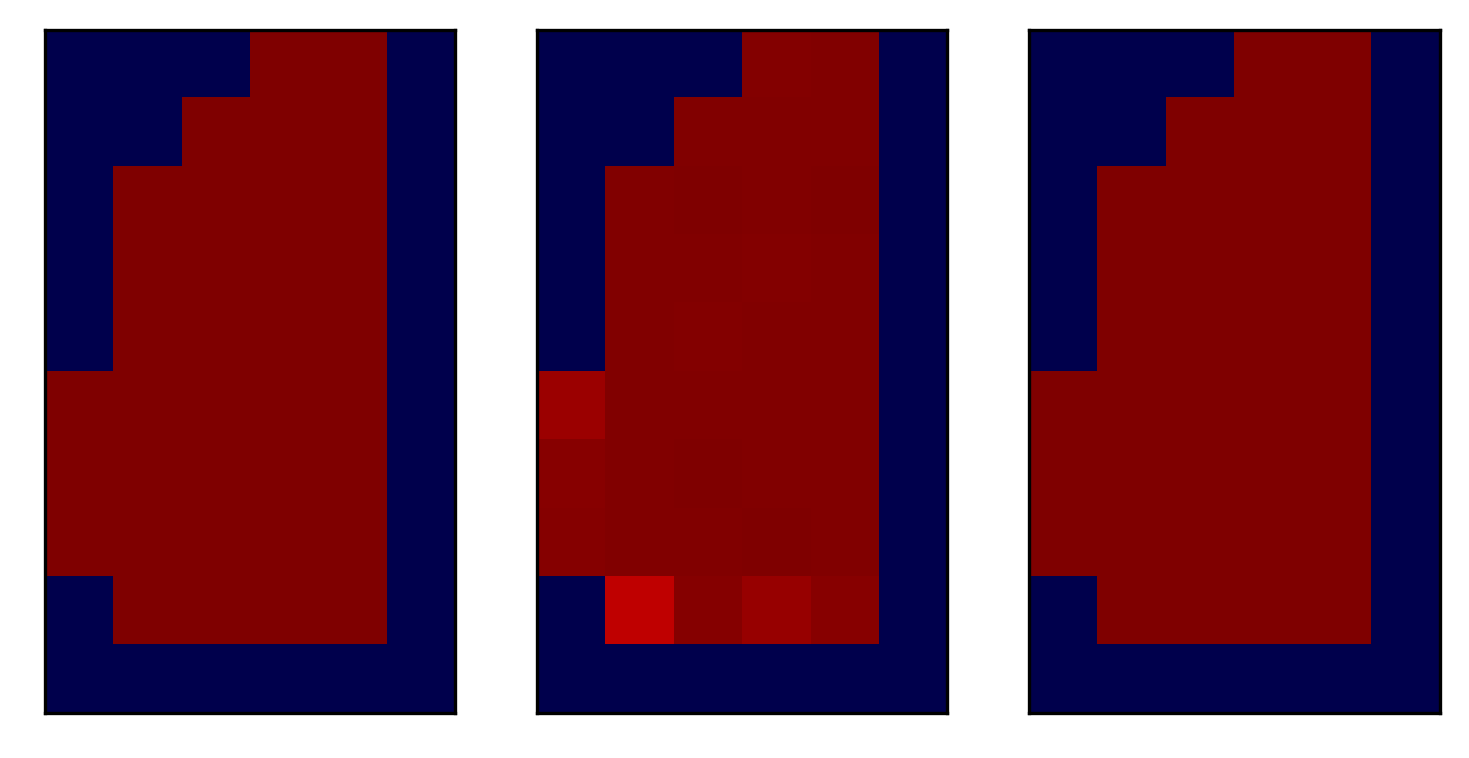

50_18_37_4018-16638A_2019-05-08 02_54_25-lv1-18037-16370-3576-4362


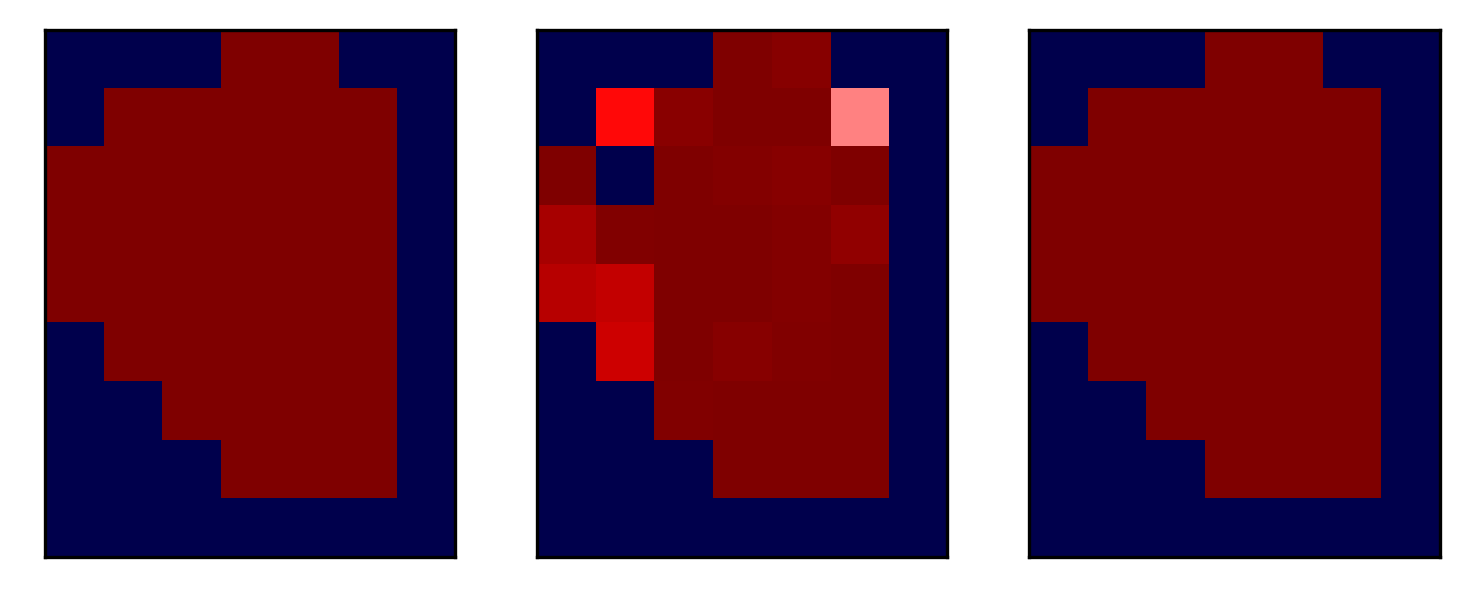

50_19_36_2918-13575A_2019-05-08 01_48_09-lv1-24486-16942-4263-6628


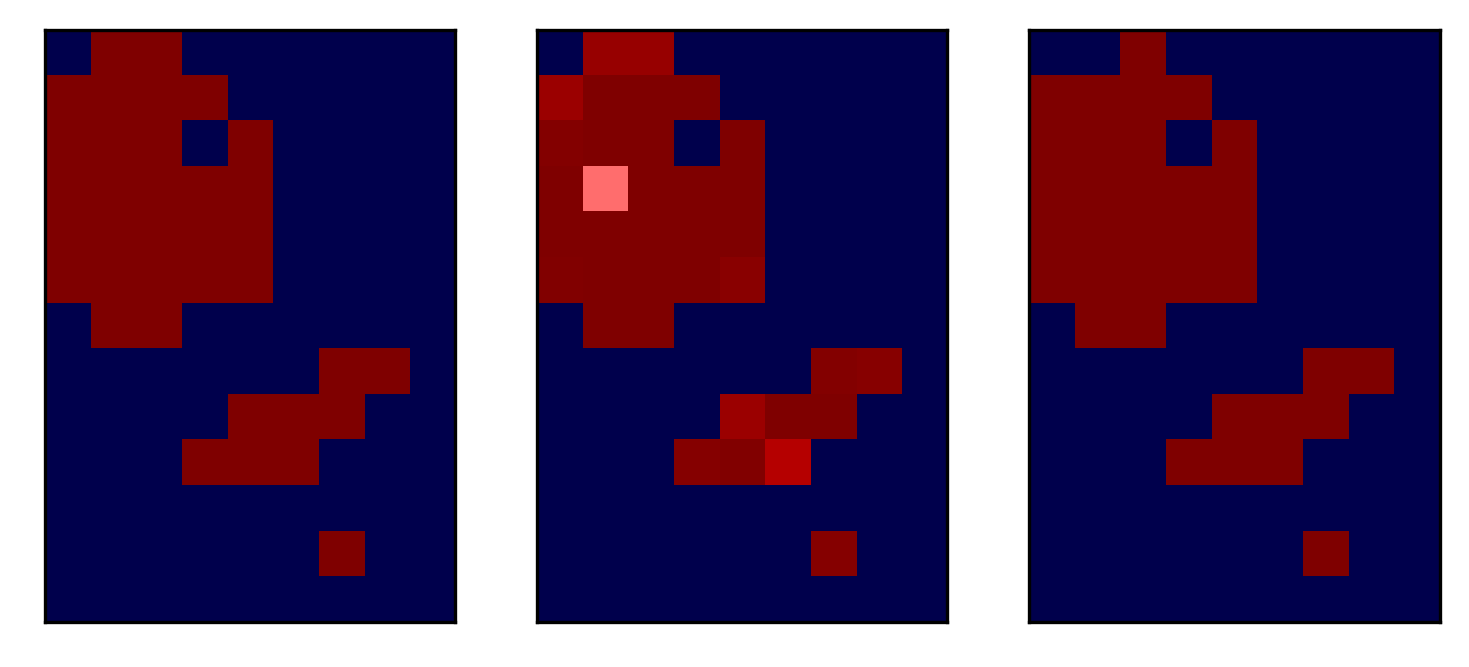

50_20_58_31900838001_2019-04-30 10_15_23-lv1-19388-22559-5824-4187


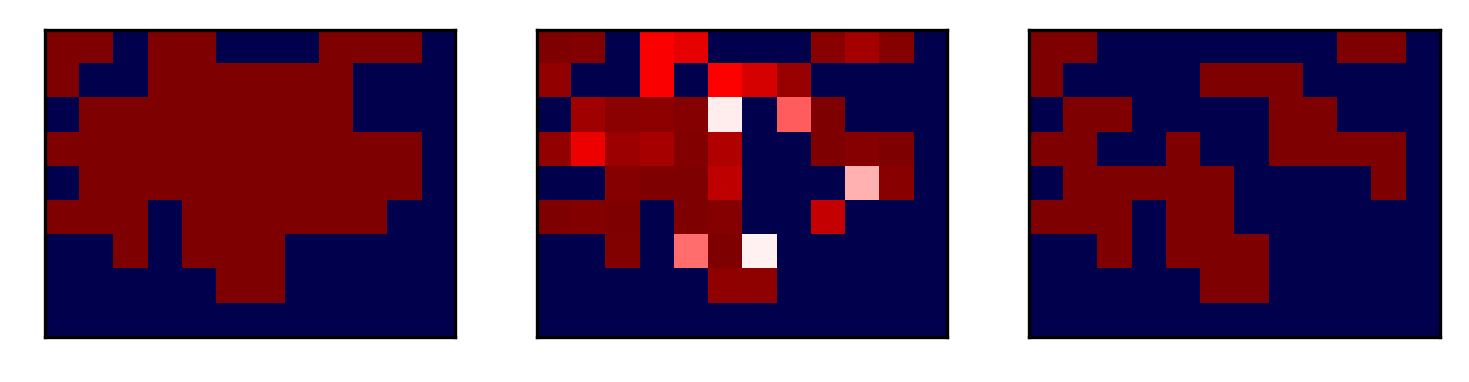

50_21_34_322018_67378_1-1_2019-02-20 22_49_25-lv1-43770-16472-3600-3412


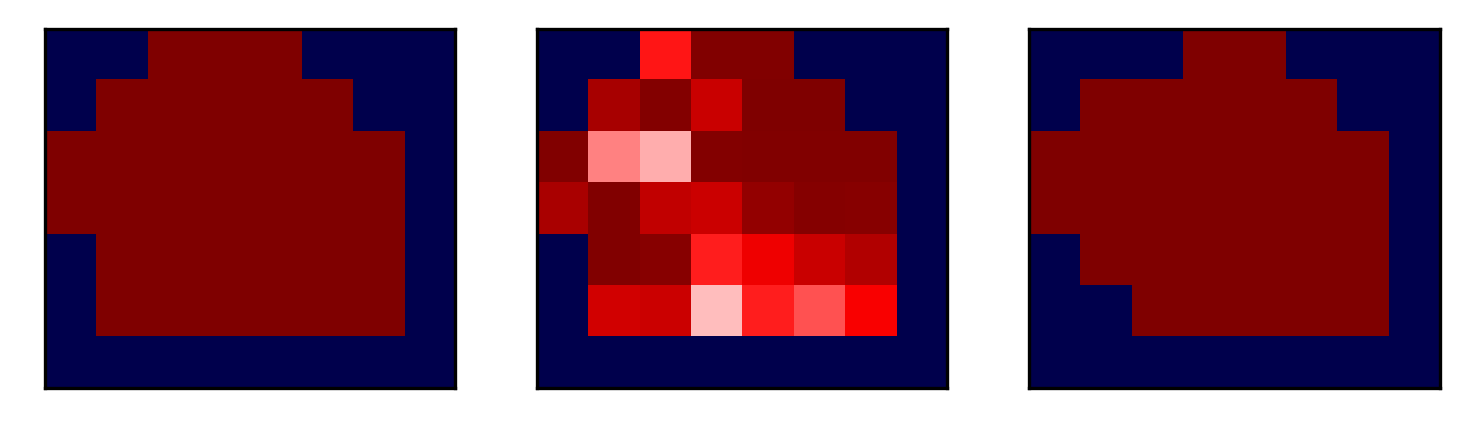

50_22_54_01901940-1_2019-04-30 10_30_47-lv1-39947-11074-3848-5785


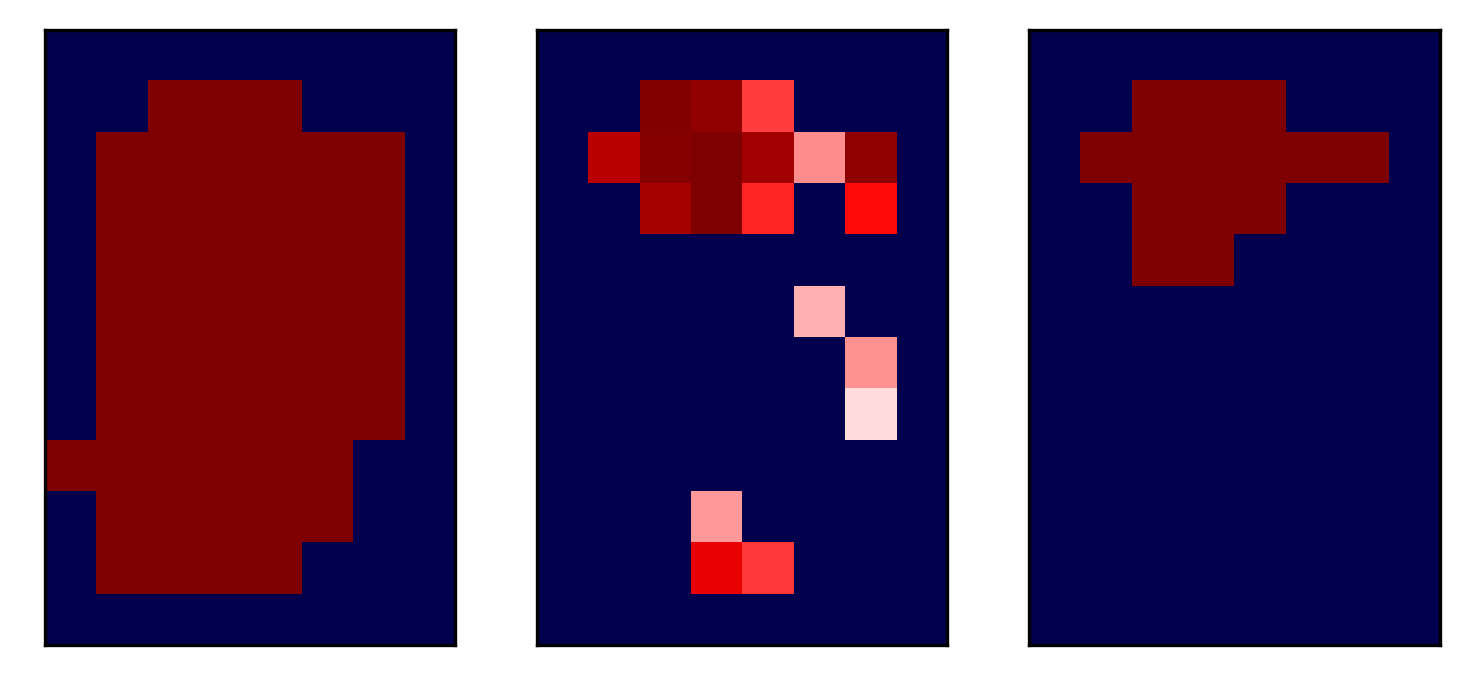

50_23_56_1218_00991B_2019-05-07 21_27_54-lv1-21230-29833-4835-6374


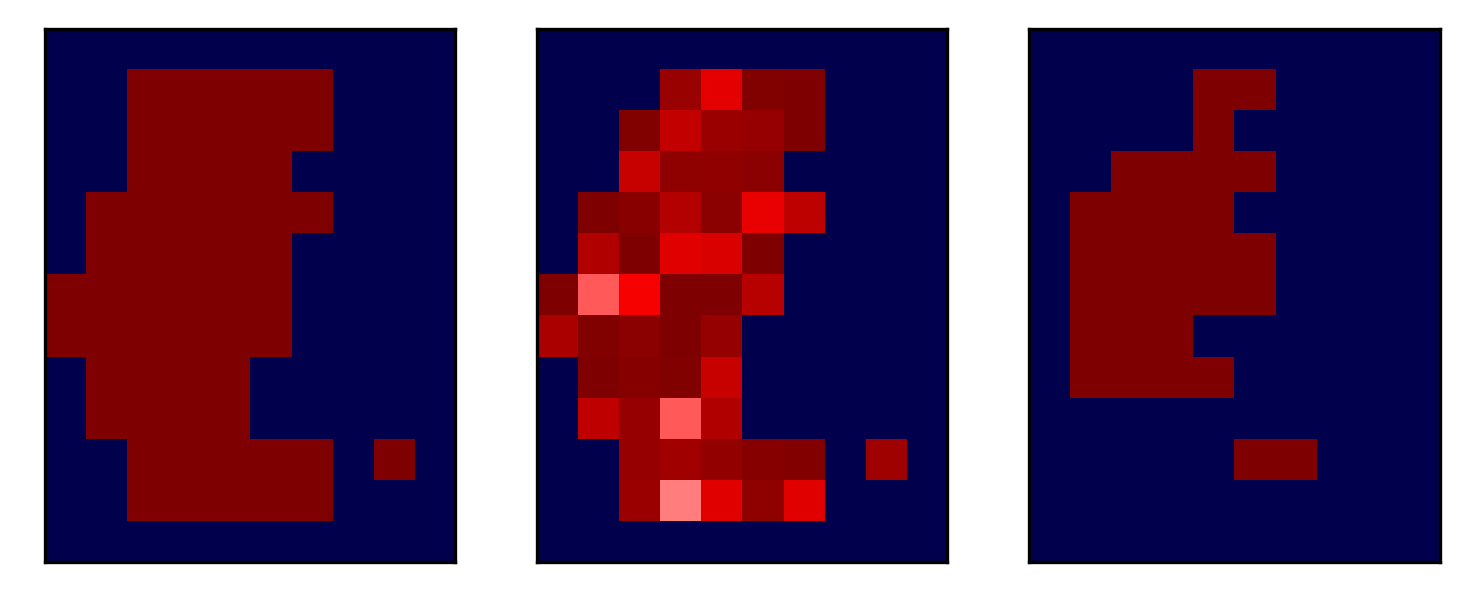

50_24_51_4218_00991B_2019-05-07 21_27_54-lv1-16174-30030-3538-5736


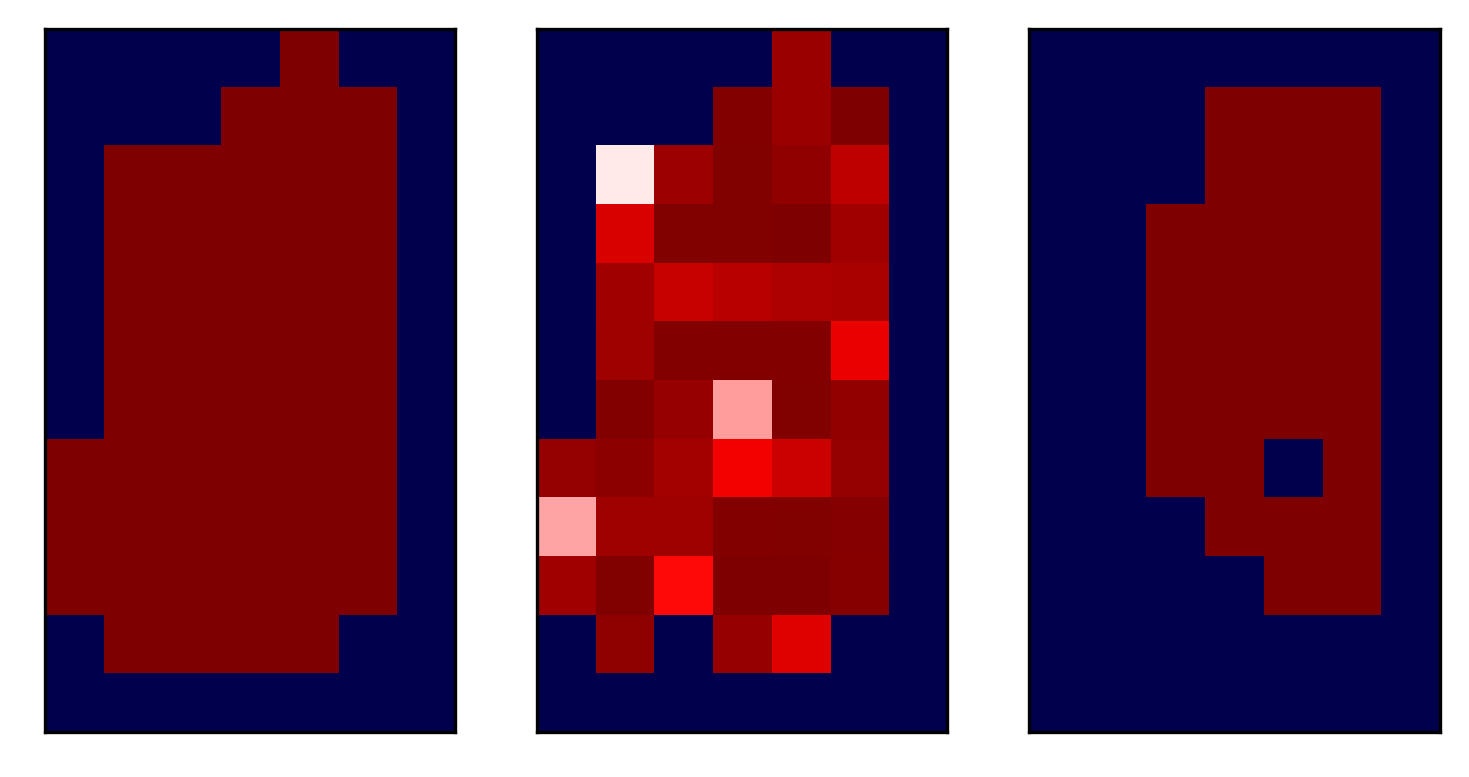

50_25_57_472018_70770_1-1_2019-02-20 23_53_21-lv1-31445-3075-5089-5065


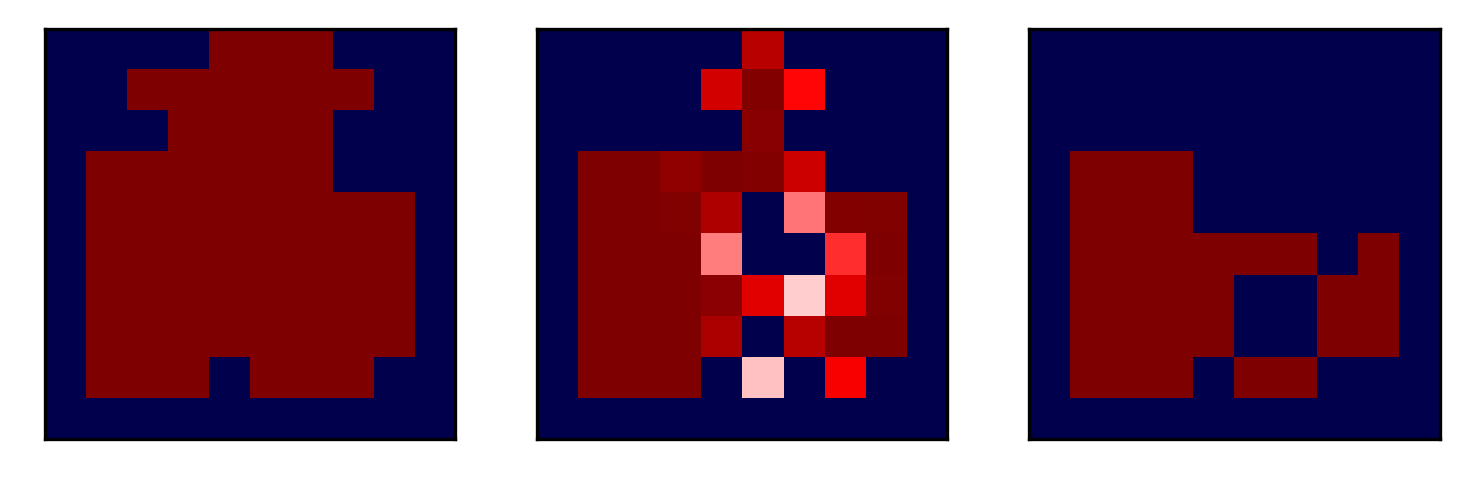

50_26_58_202018_68099_1-1_2019-02-20 23_21_13-lv1-7948-15919-4988-5294


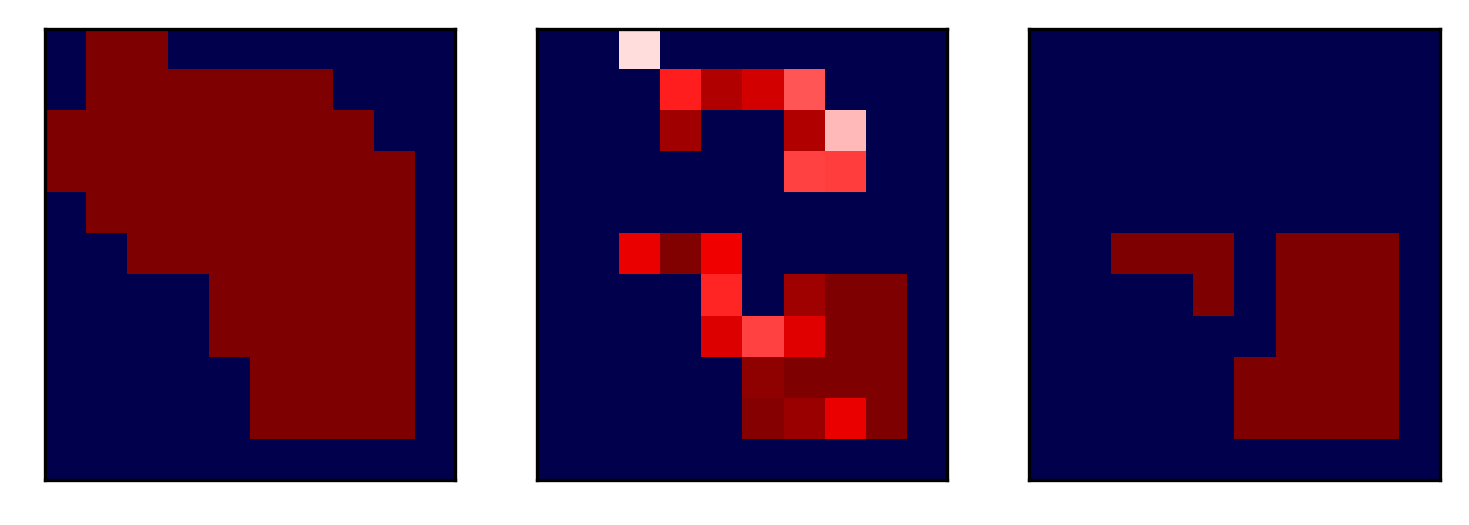

50_27_42_142018_67378_1-1_2019-02-20 22_49_25-lv1-41264-9330-5423-3812


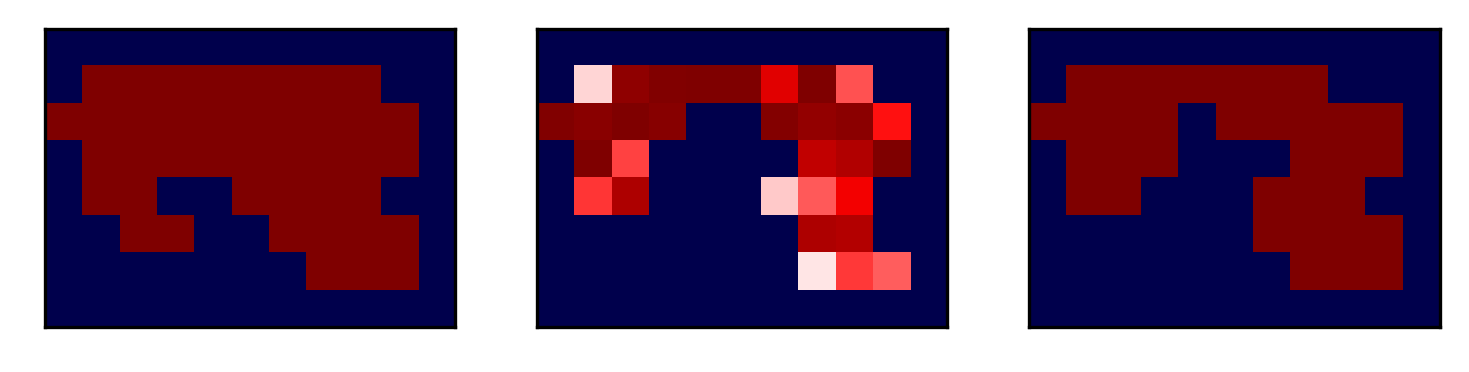

50_28_54_92018_62532_1-1_2019-02-20 21_54_51-lv1-48484-29236-5435-5412


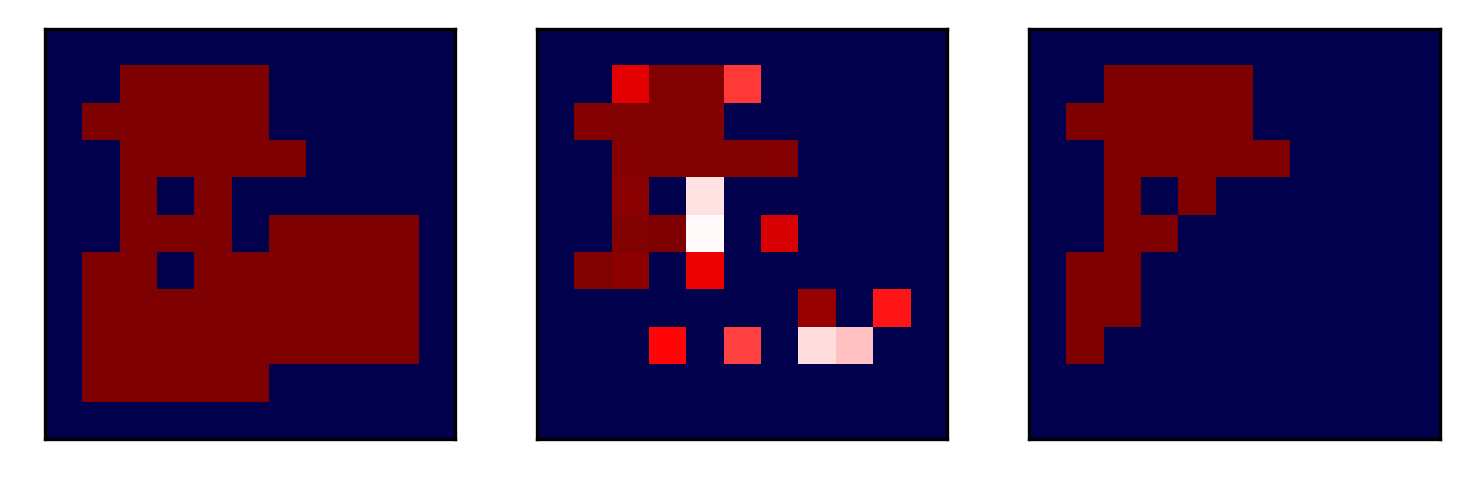

50_29_40_3318-14278B_2019-05-08 02_13_11-lv1-13964-11229-3779-5973


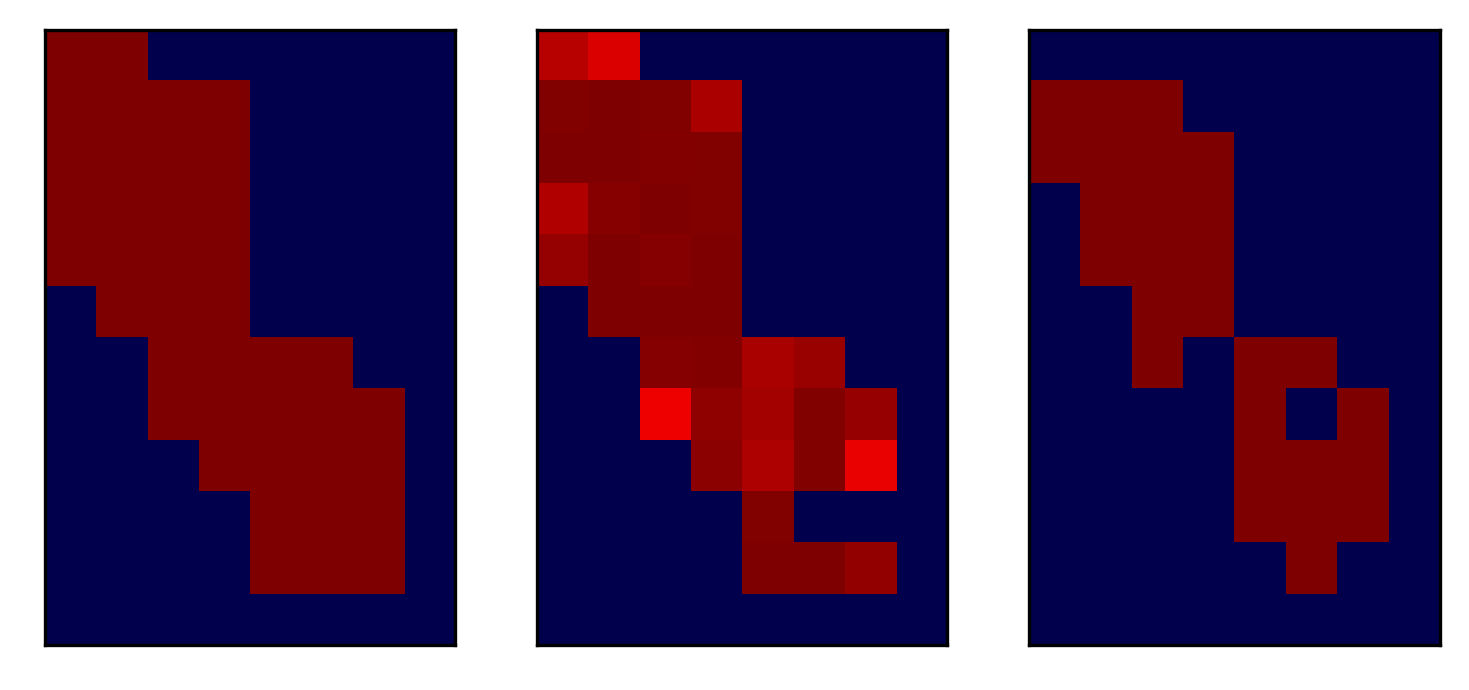

50_30_39_2118-15948A_2019-05-08 2_39_44-lv1-3890-15585-4835-3398


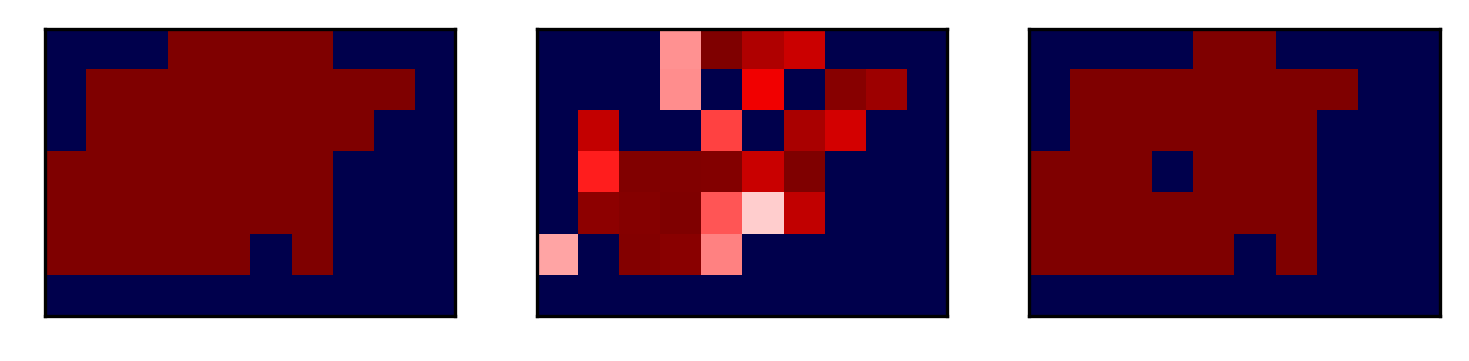

50_31_58_1818-14278B_2019-05-08 02_13_11-lv1-17874-10382-3996-6342


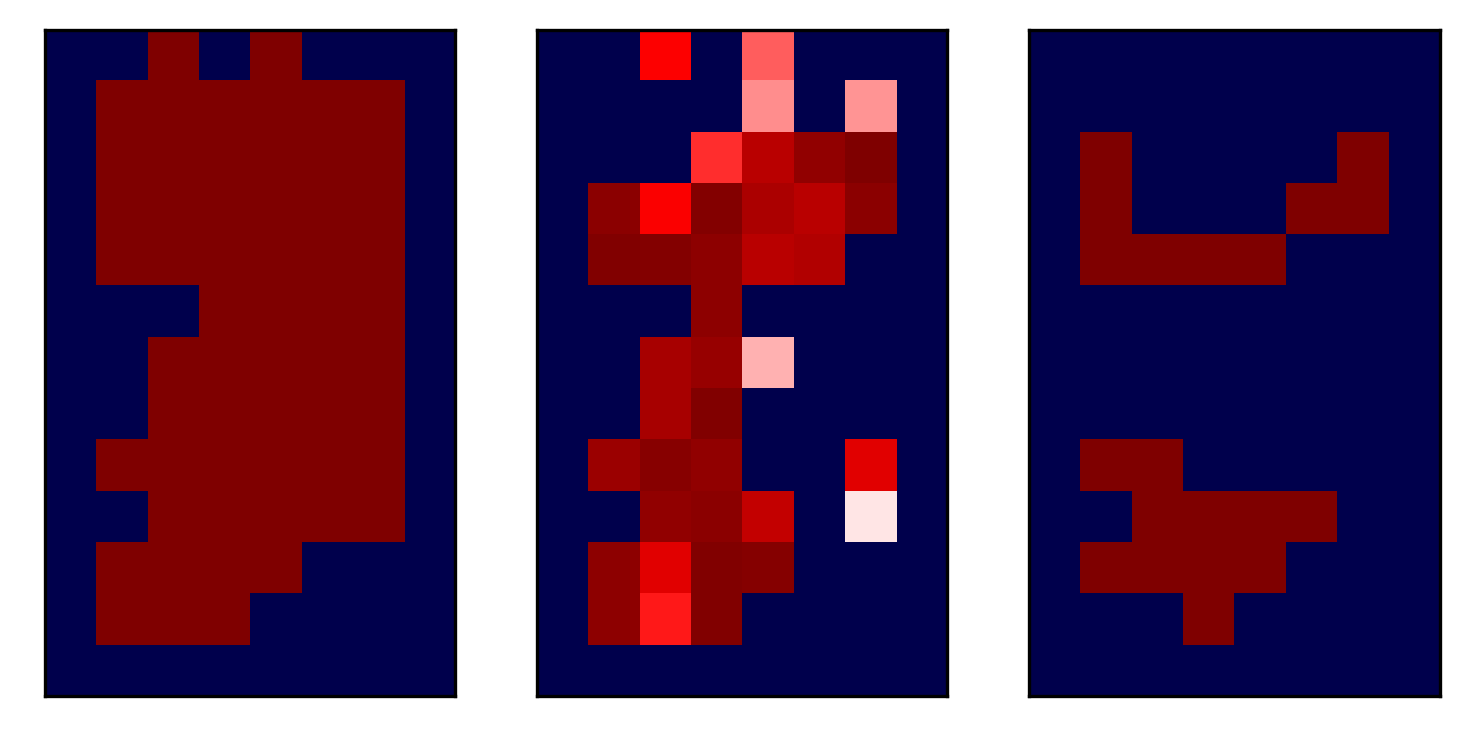

50_32_26_441900838001_2019-04-30 10_15_23-lv1-17110-19166-3362-4373


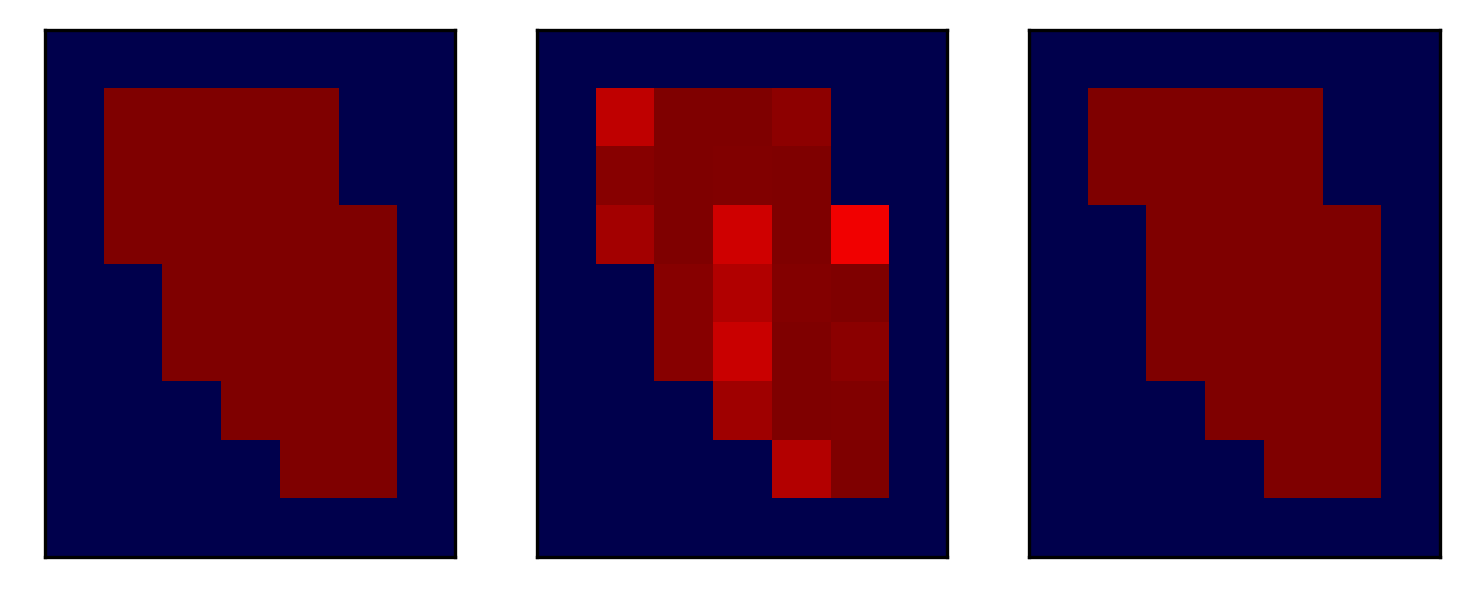

50_33_37_241800127001_2019-04-30 10_40_02-lv1-6892-18147-4571-3989


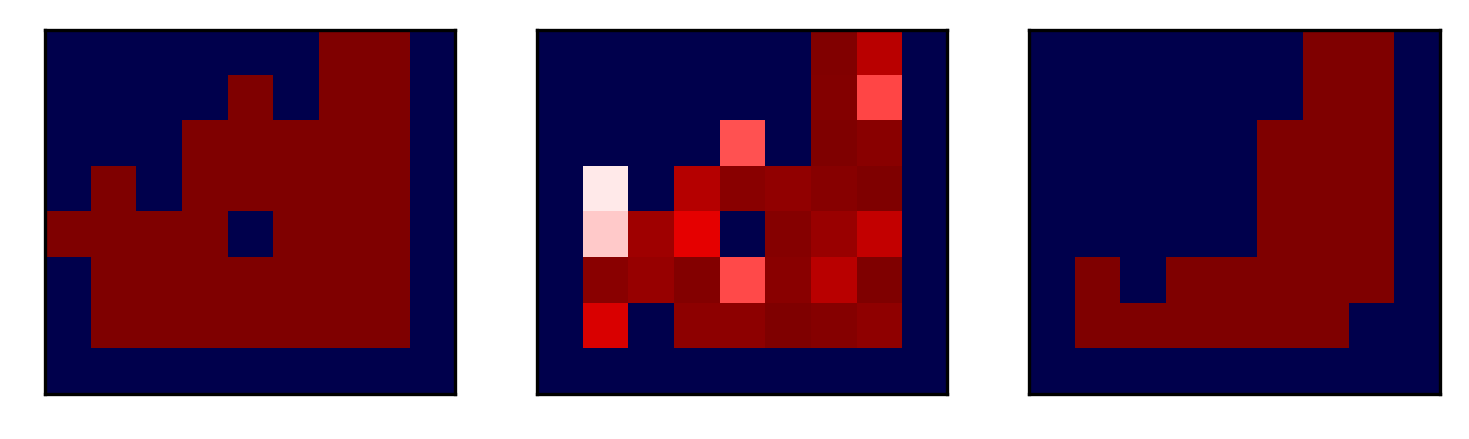

50_34_24_281800127001_2019-04-30 10_40_02-lv1-7573-15422-4121-2549


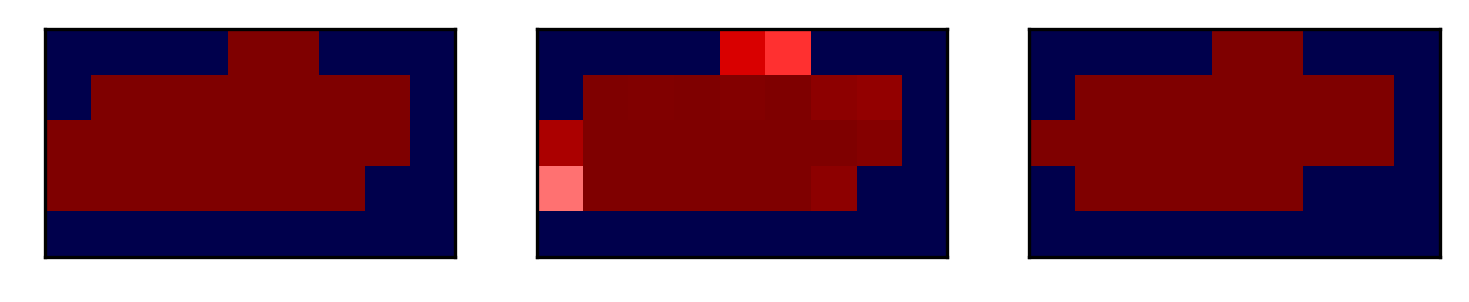

50_35_34_451901558001_2019-04-30 10_24_11-lv1-54922-32041-3594-3236


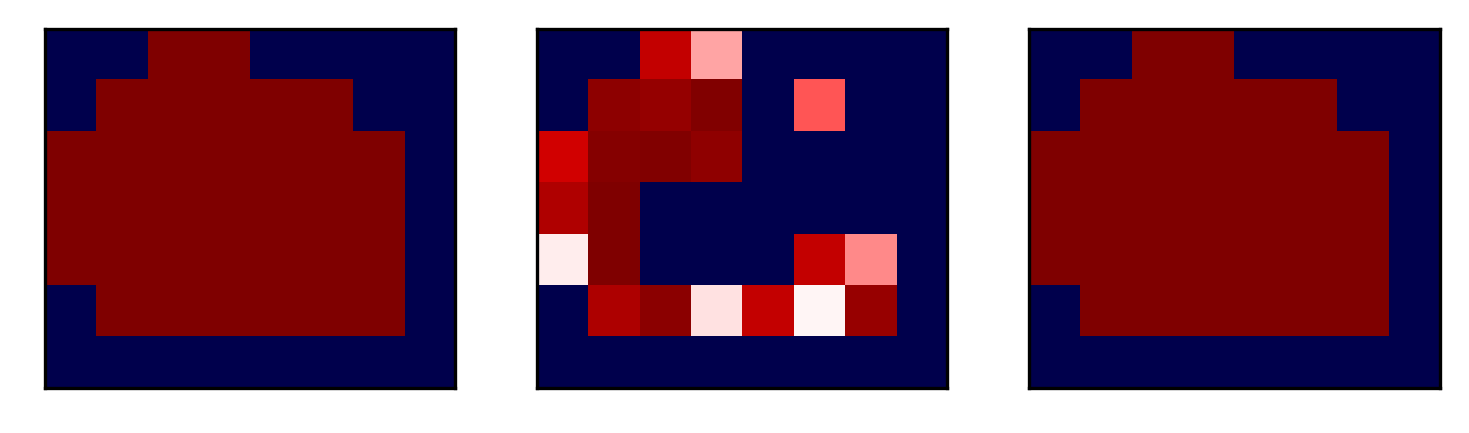

50_36_32_481901558001_2019-04-30 10_24_11-lv1-53781-36766-3290-3779


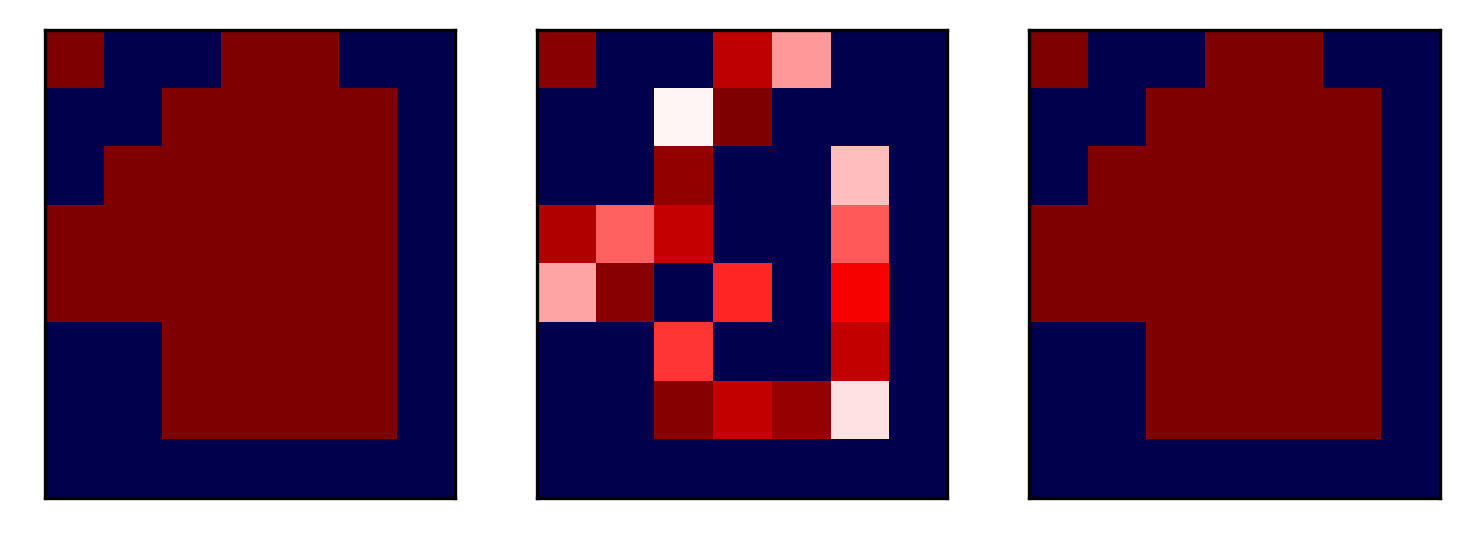

50_37_43_231901067001_2019-04-30 10_36_04-lv1-17809-14080-2848-6199


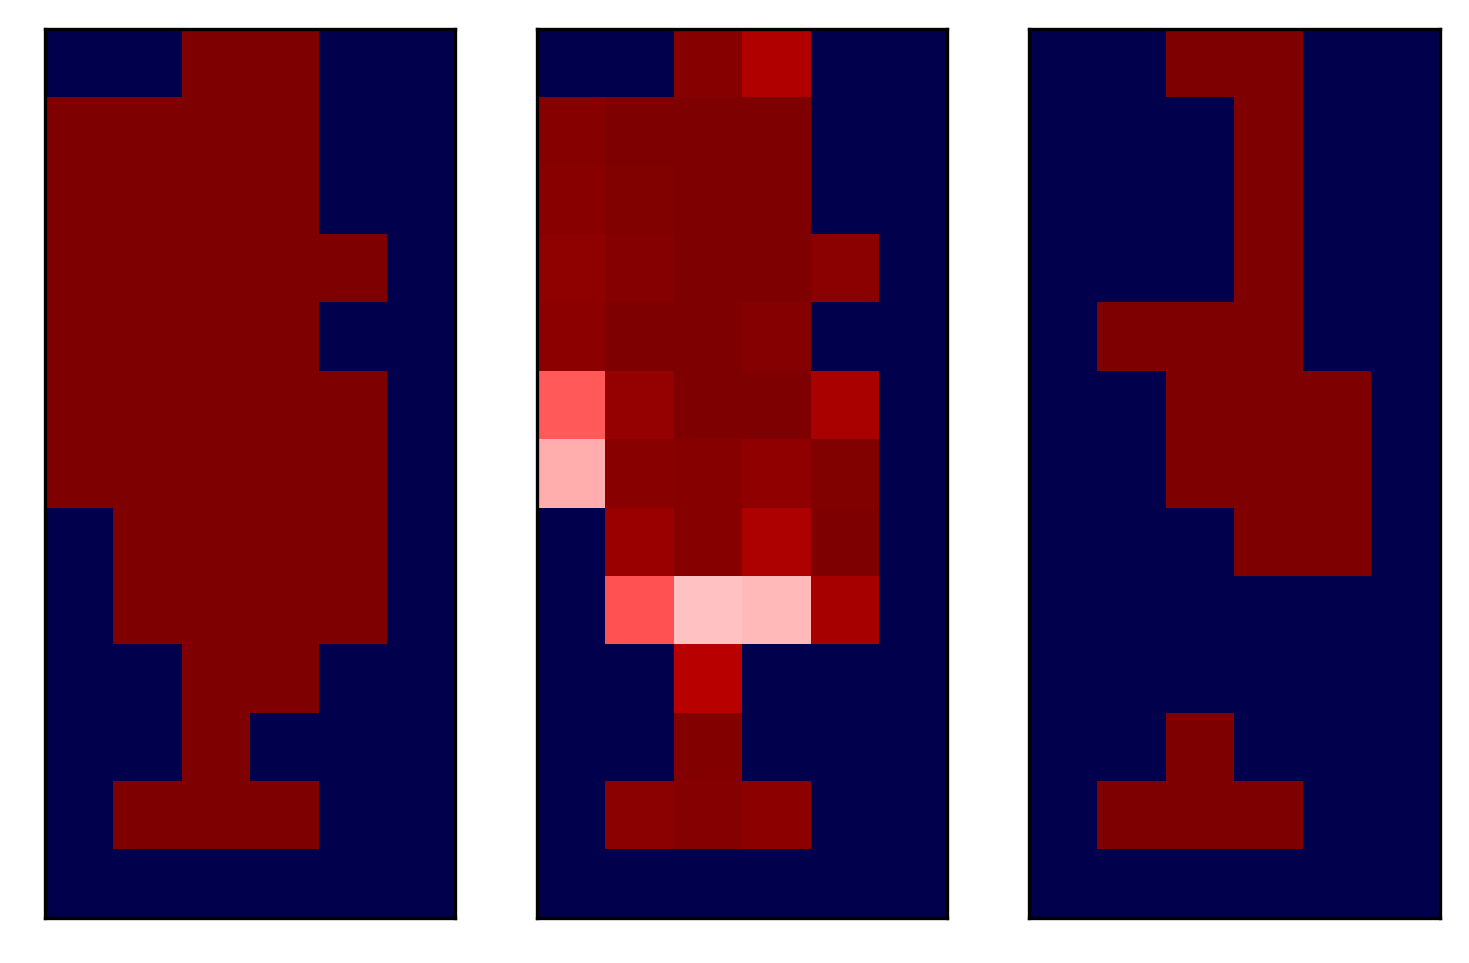

50_38_21_4918-13575A_2019-05-08 01_48_09-lv1-21060-17798-2829-6367


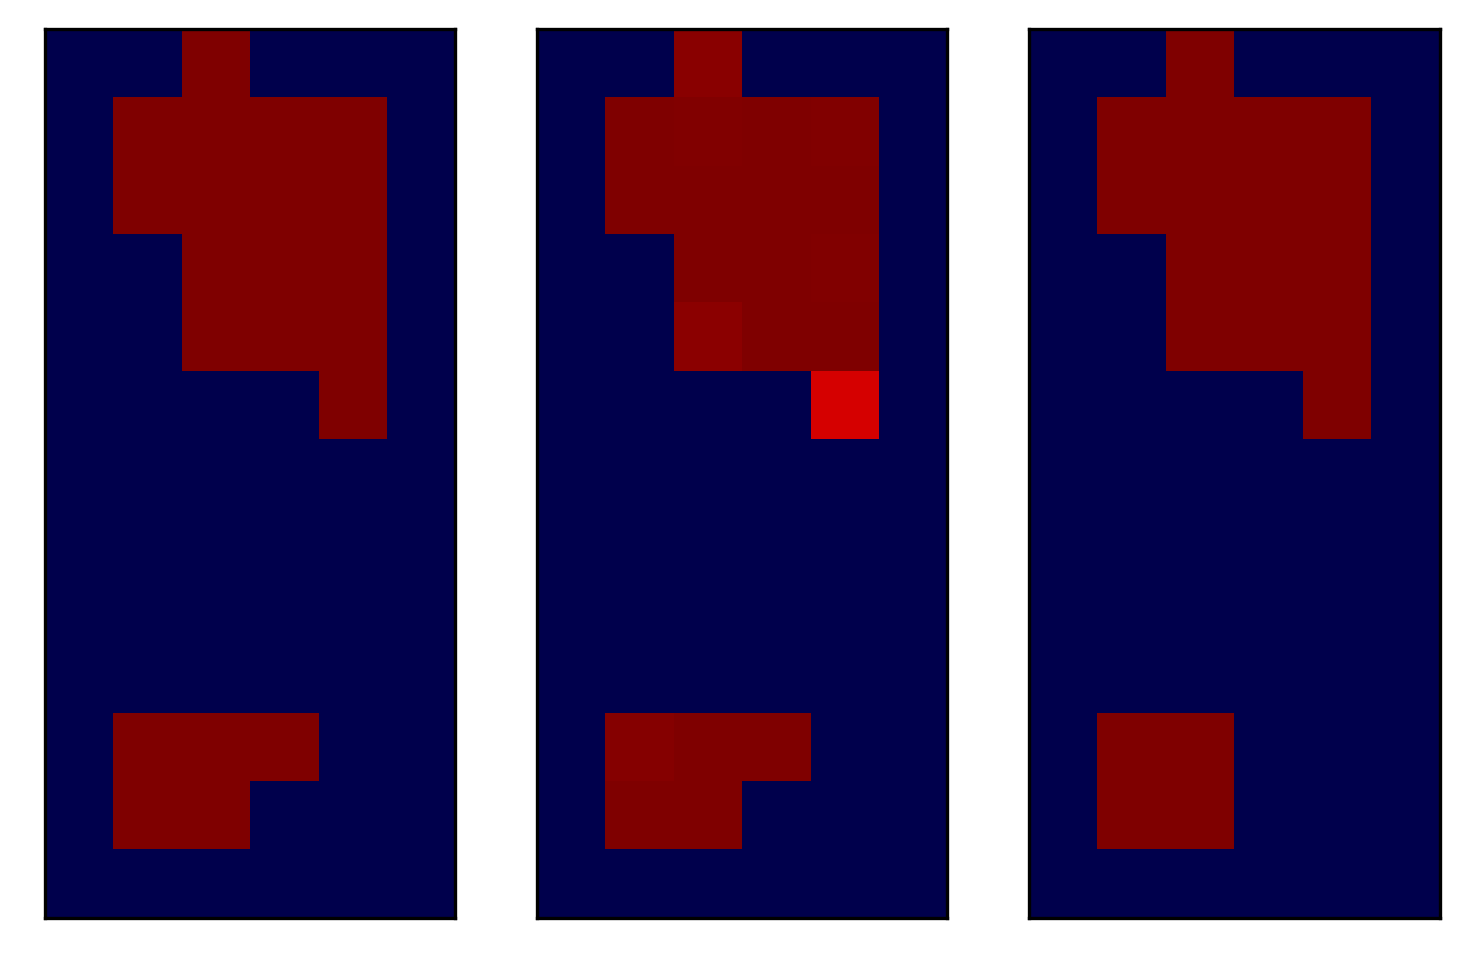

50_39_33_372018_67378_1-1_2019-02-20 22_49_25-lv1-46888-12754-2988-4306


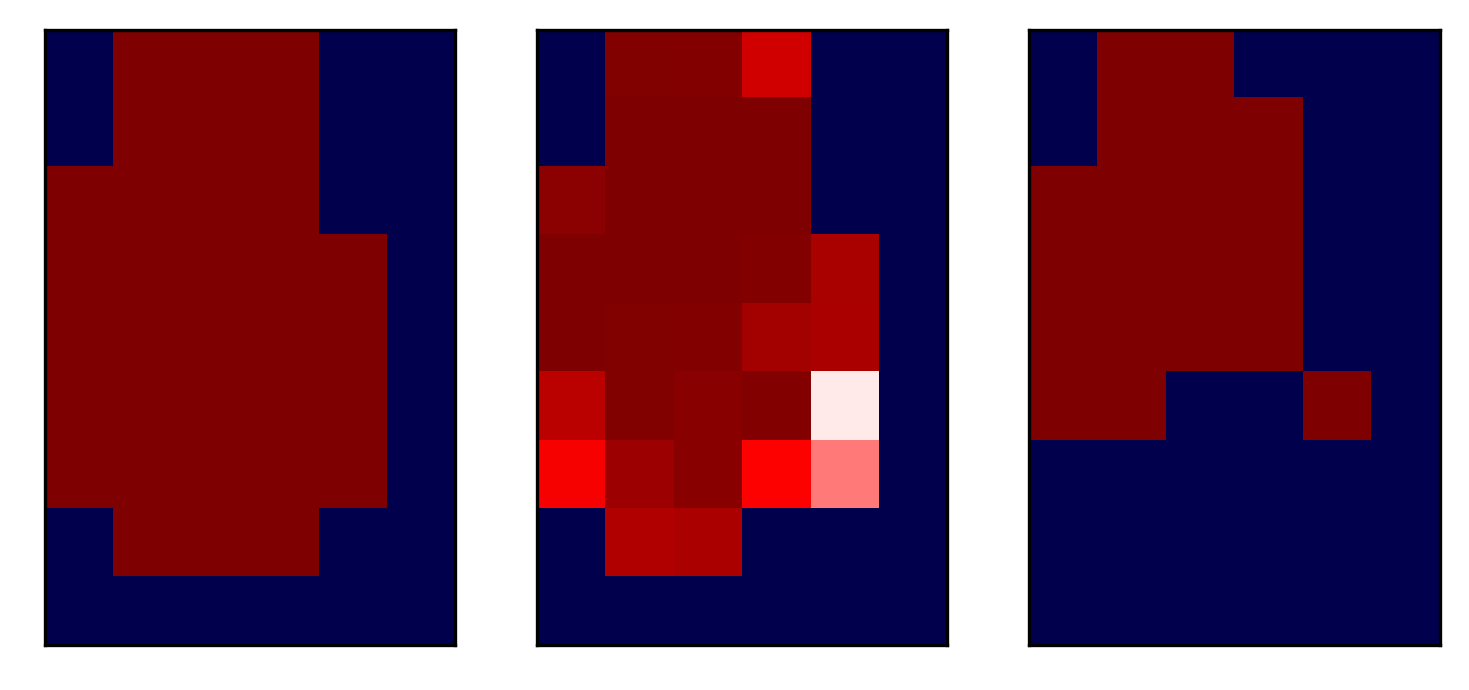

50_40_34_1118-15948A_2019-05-08 2_39_44-lv1-1998-10776-6940-4790


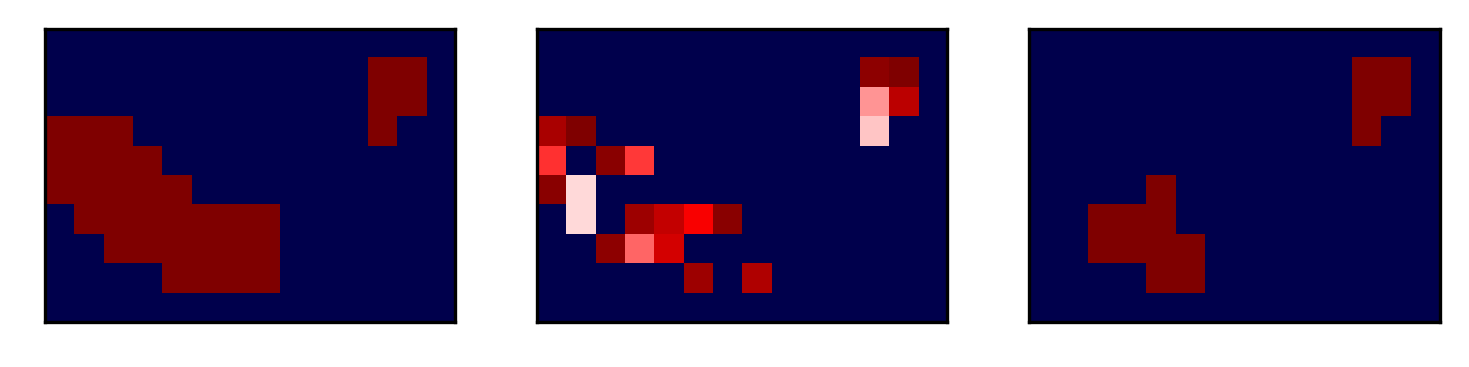

50_41_31_41800883002_2019-04-30 09_57_31-lv1-32373-29627-2888-5031


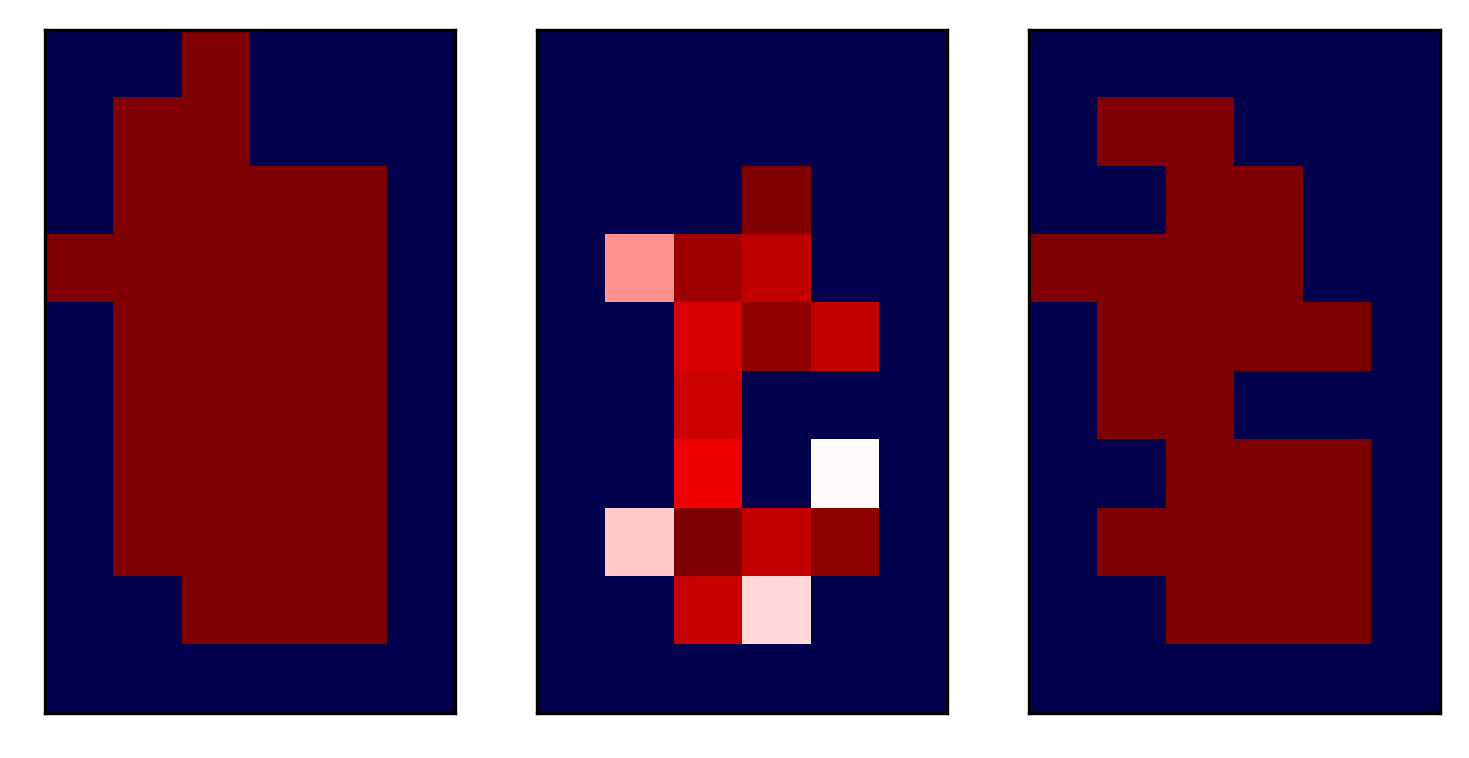

50_42_25_72018_68099_1-1_2019-02-20 23_21_13-lv1-18019-14672-3129-3364


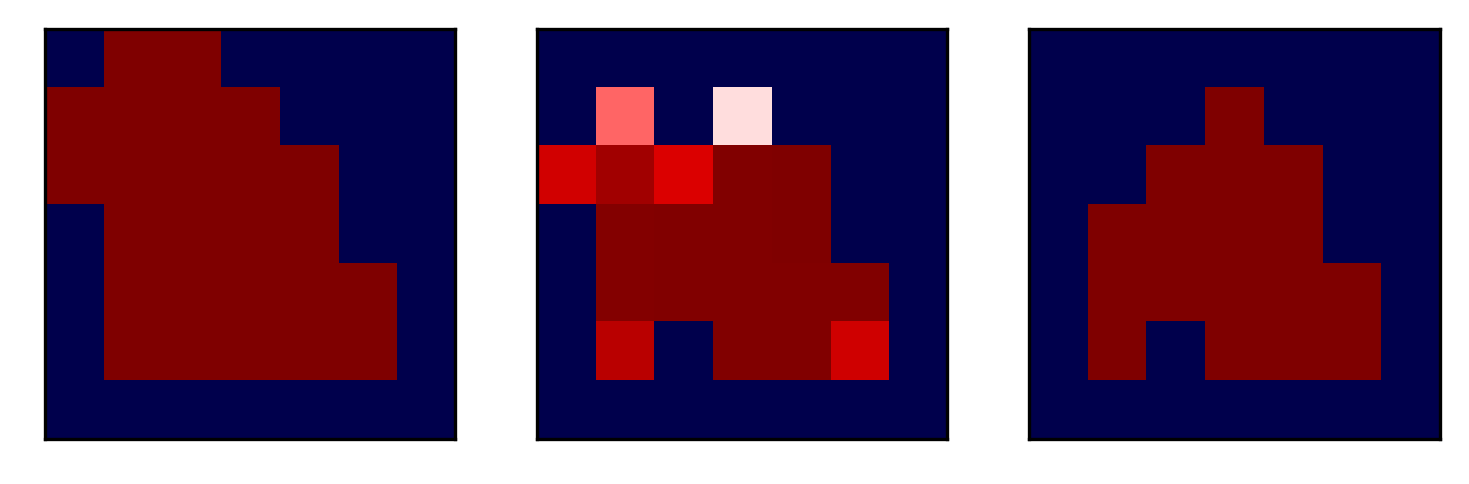

50_43_34_61800127001_2019-04-30 10_40_02-lv1-1001-22444-3989-3967


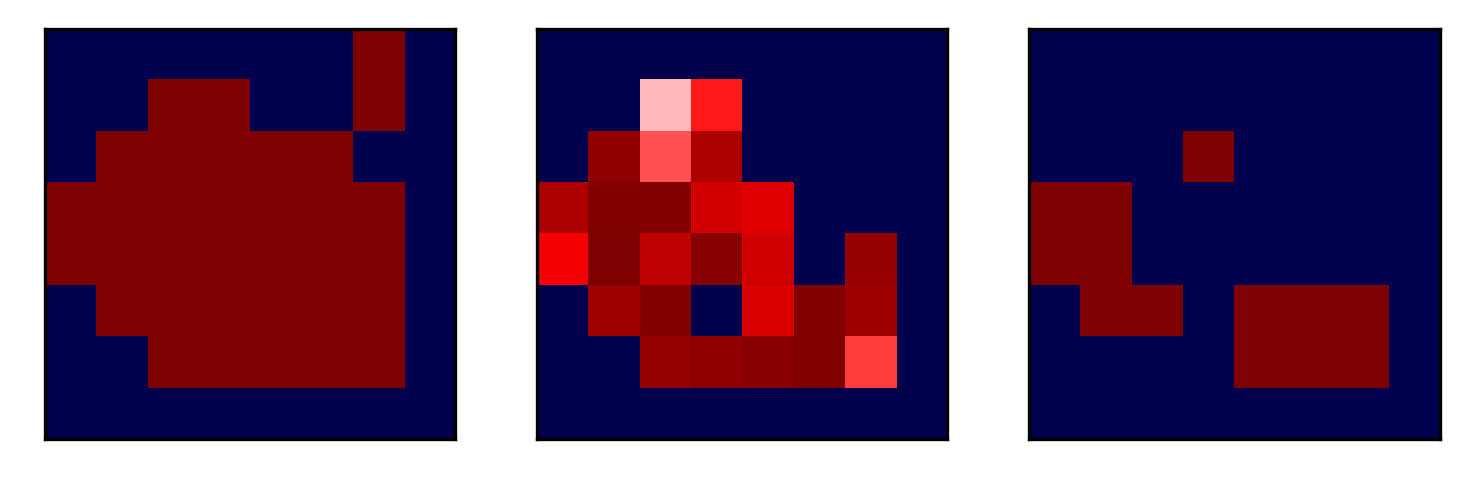

50_44_28_152018_70770_1-1_2019-02-20 23_53_21-lv1-39165-4987-3338-4289


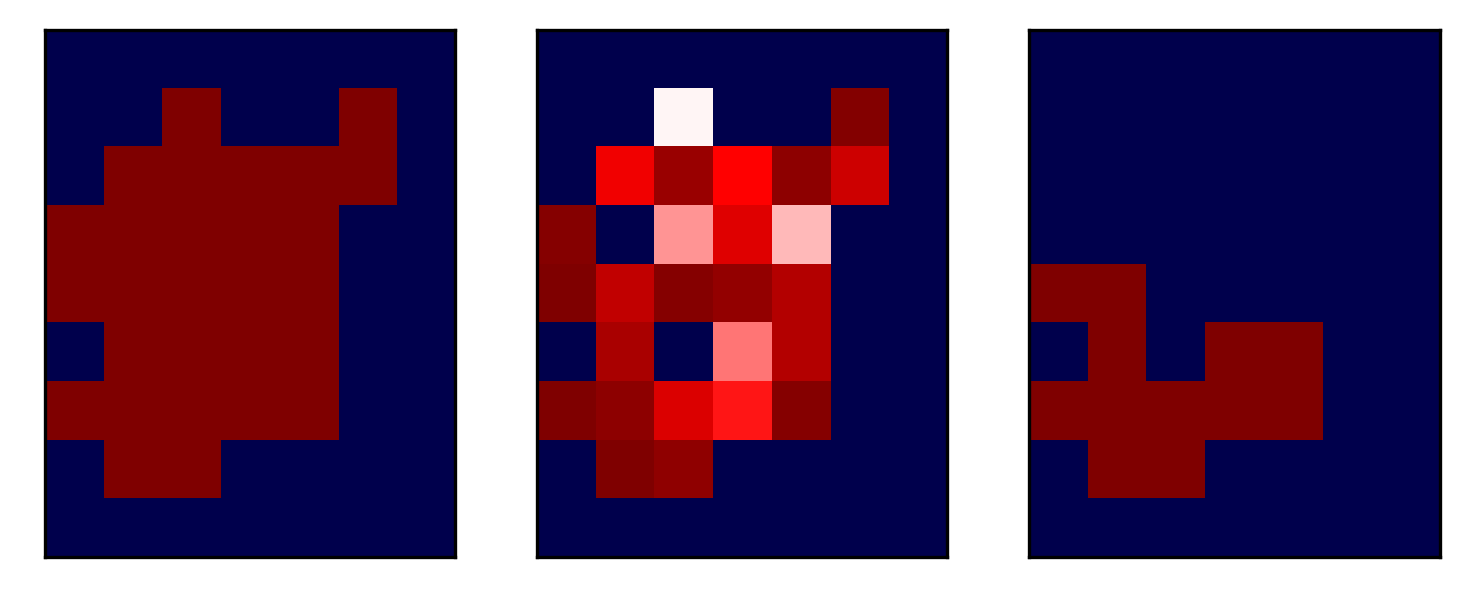

50_45_45_341800127001_2019-04-30 10_40_02-lv1-6628-22213-4692-4725


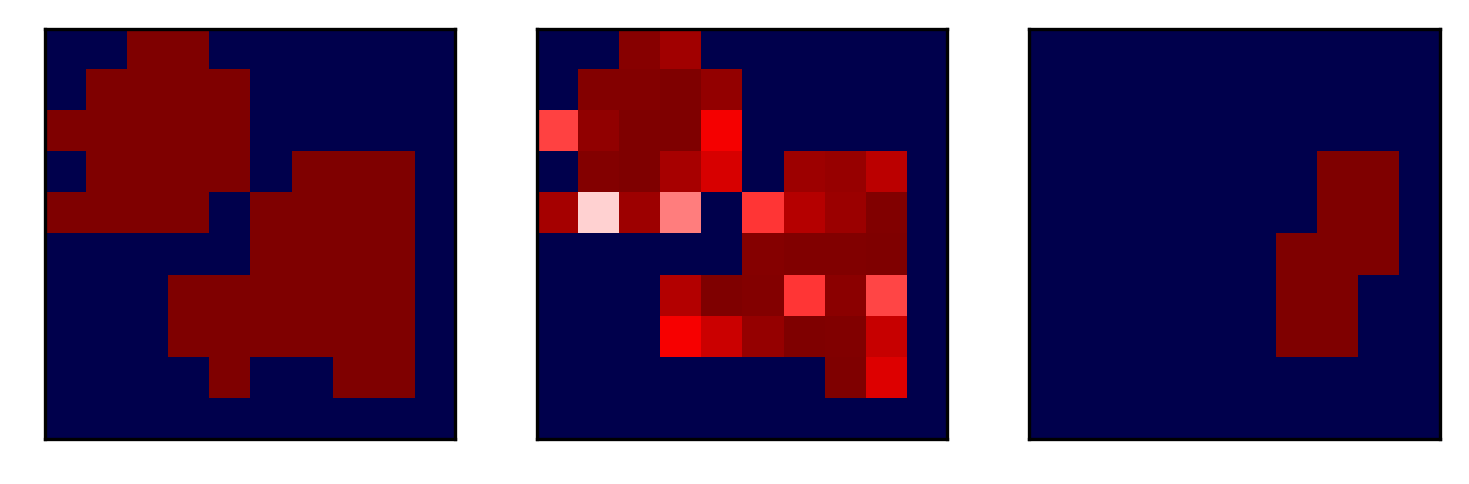

50_46_15_361800127001_2019-04-30 10_40_02-lv1-4386-16301-2230-4582


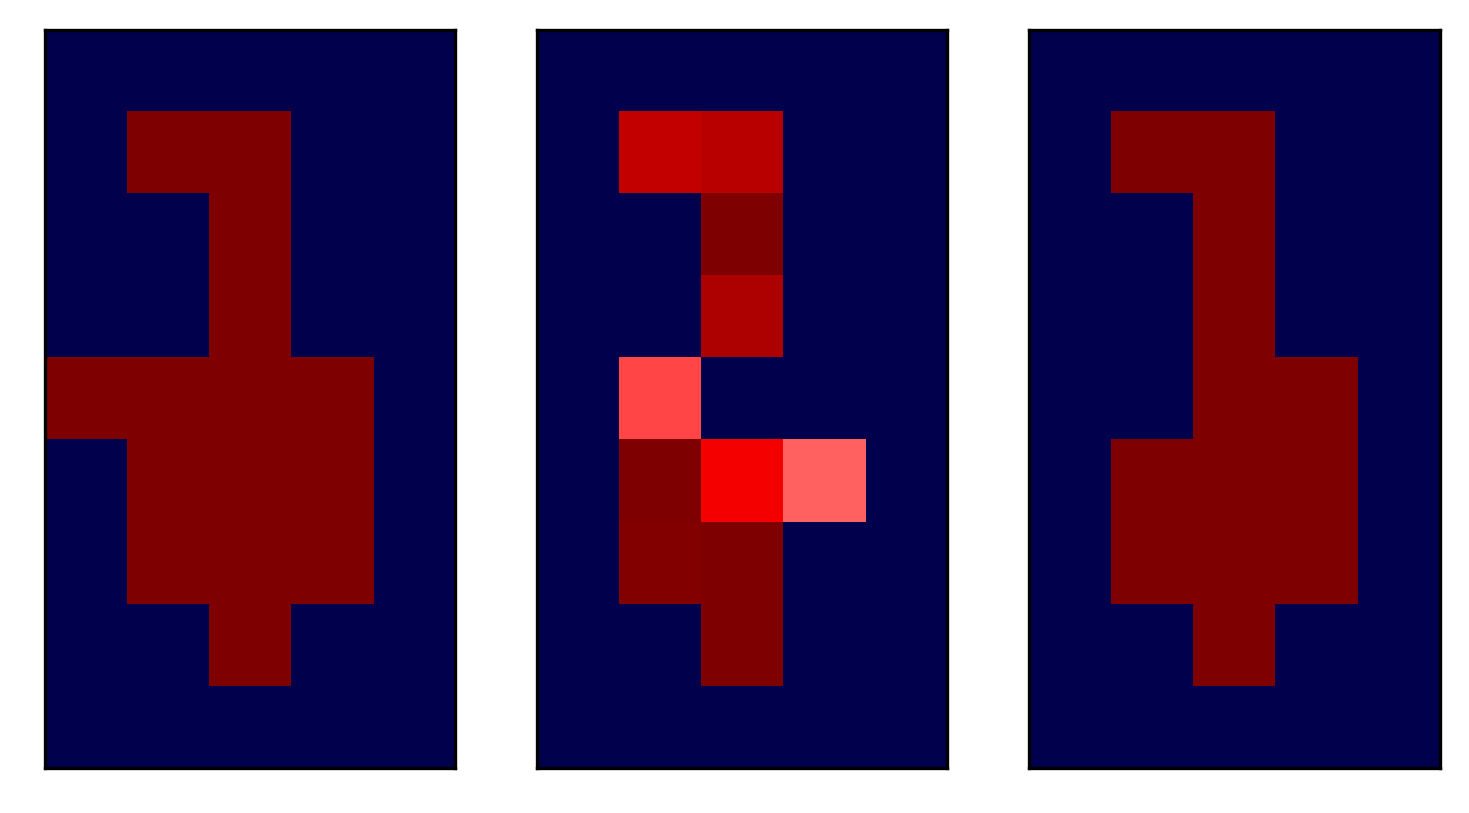

50_47_18_131901067001_2019-04-30 10_36_04-lv1-20509-14477-2904-3369


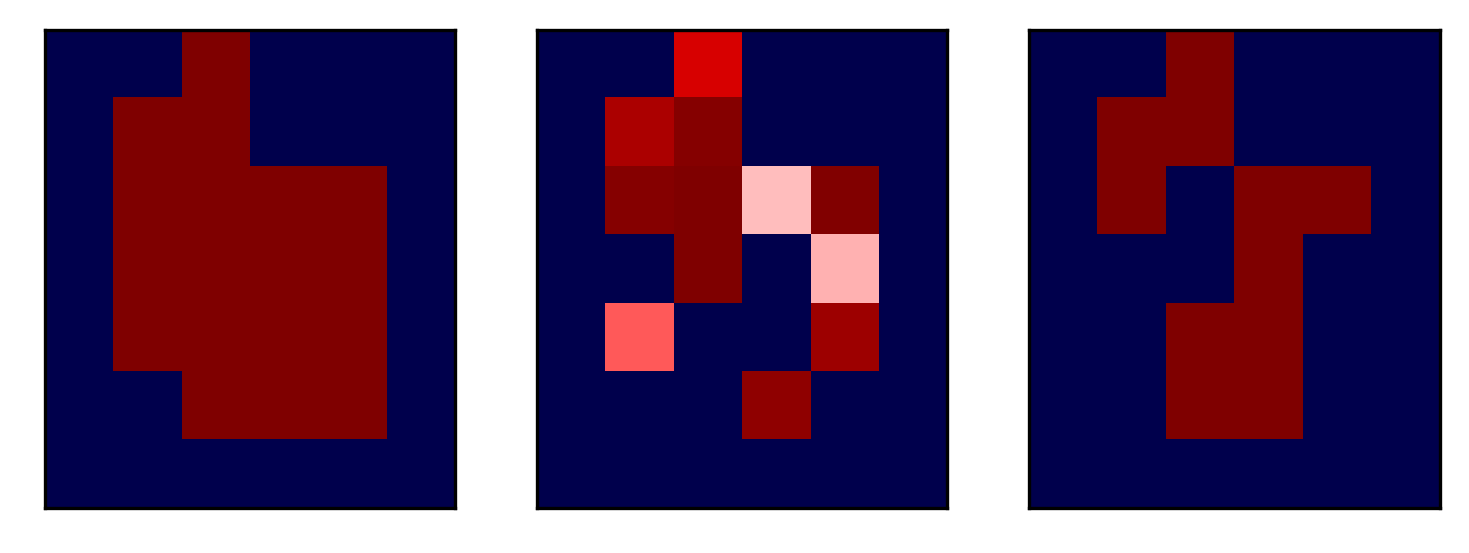

50_48_15_461800883002_2019-04-30 09_57_31-lv1-28885-30819-3472-3263


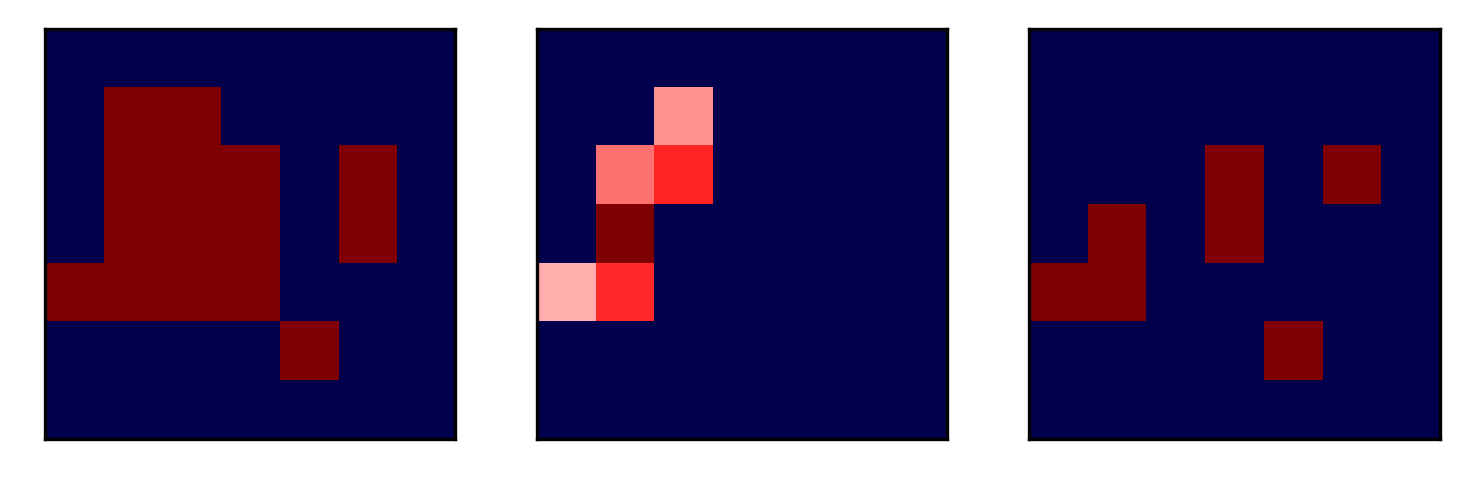

50_49_15_3018-13575A_2019-05-08 01_48_09-lv1-17672-19213-3072-3239


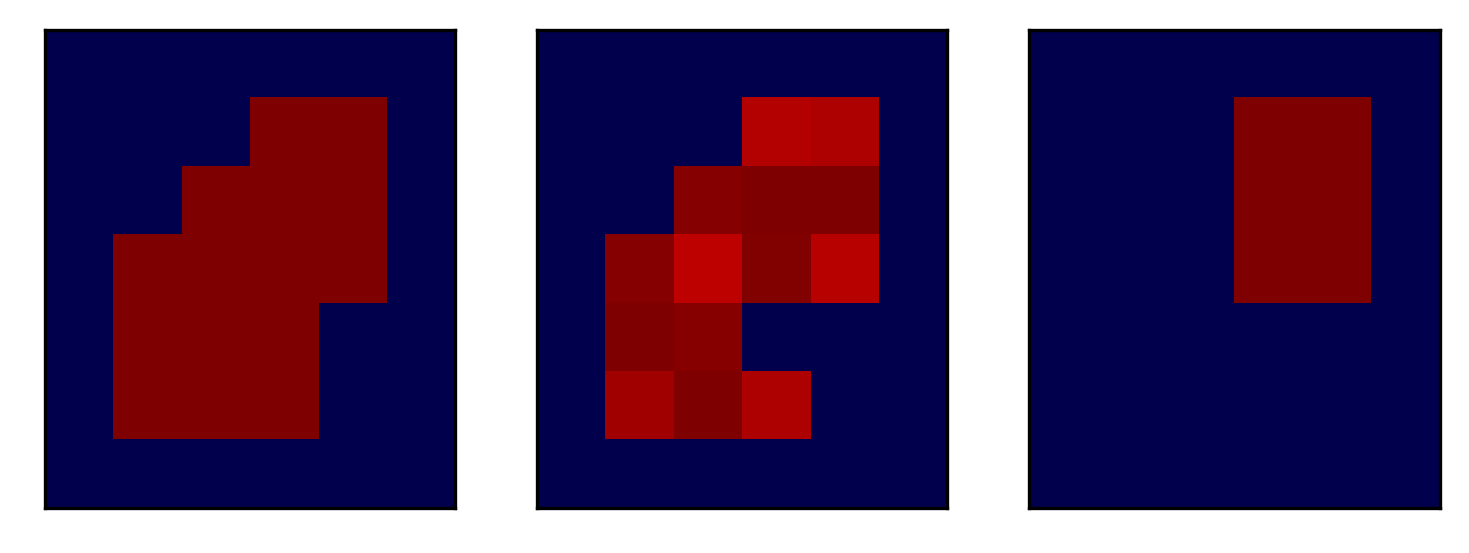

In [4]:
#heatmap
for i in range(len(indices)): #len(indices)
    chosen_idx = indices[i].item()
    bag_len = len(bag_labels_in_list[chosen_idx])
#     print('baglen',len(bag_labels_in_list[chosen_idx]))
    one_path =  path_in_list[chosen_idx][0].split('/')[-2]
    chosen_x = idx_xs[chosen_idx]
    chosen_y = idx_ys[chosen_idx]
    real_x = idx_xs[chosen_idx][bag_labels_in_list[chosen_idx]==1]
    real_y = idx_ys[chosen_idx][bag_labels_in_list[chosen_idx]==1]
    # chosen_x ,chosen_y, real_x, real_y
    tmp = np.zeros((idx_xs[chosen_idx].max()+2,idx_ys[chosen_idx].max()+2))
    tmp[chosen_x,chosen_y]=t_neg_preds_in_list[chosen_idx].squeeze(-1)
    from PIL import Image
    import matplotlib.pyplot as plt
    A= Image.fromarray(np.uint8(tmp*255))
    
    tmp = np.zeros((idx_xs[chosen_idx].max()+2,idx_ys[chosen_idx].max()+2))
    tmp[real_x,real_y ]=1
    B= Image.fromarray(np.uint8(tmp*255))
    tmp = np.zeros((idx_xs[chosen_idx].max()+2,idx_ys[chosen_idx].max()+2))
    tmp[idx_xs[chosen_idx],idx_ys[chosen_idx] ]=1
    
    C= Image.fromarray(np.uint8(tmp*255))
    img_list = [C, A, B]
    
    plt.rcParams['savefig.dpi'] = 300 #图片像素
    plt.rcParams['figure.dpi'] = 300 #分辨率
    plt.figure()
    import os 
    if not os.path.exists(os.path.join(trainer.logger.logdir, 'pred_figs',str(epoch))):
            os.makedirs(os.path.join(trainer.logger.logdir, 'pred_figs',str(epoch)))
    for j in range(1,4):
        plt.subplot(1,3,j)
        plt.imshow(img_list[j-1],cmap='seismic')
        plt.xticks([])
        plt.yticks([])
        plt.savefig(os.path.join(trainer.logger.logdir, 'pred_figs',str(epoch) , "{}.png".format(str(epoch)+'_'+str(i)+'_'+str(bag_len)+'_'+str(chosen_idx)+one_path)), dpi=300)
    print('{}'.format((str(epoch)+'_'+str(i)+'_'+str(bag_len)+'_'+str(chosen_idx)+one_path)))
    plt.show() # real vs learned, name:epoch+rank+bag_len+bag_num

tensor([0.9048, 0.8750, 0.8649, 0.8333, 0.8077, 0.8000, 0.8000, 0.7949, 0.7941,
        0.7917, 0.7841, 0.7778, 0.7759, 0.7692, 0.7586, 0.7419, 0.7179, 0.7143,
        0.7083, 0.7059, 0.6957, 0.6935, 0.6923, 0.6905, 0.6809, 0.6750, 0.6667,
        0.6642, 0.6486, 0.6111, 0.6071, 0.6000, 0.6000, 0.5976, 0.5862, 0.5789,
        0.5686, 0.5455, 0.5357, 0.5000, 0.4884, 0.4783, 0.4667, 0.4630, 0.4600,
        0.4444, 0.4138, 0.3793, 0.3750, 0.3478, 0.3396, 0.3333, 0.3333, 0.3235,
        0.3214, 0.3148, 0.3043, 0.2833, 0.2830, 0.2812, 0.2778, 0.2778, 0.2759,
        0.2653, 0.2593, 0.2581, 0.2549, 0.2432, 0.2432, 0.2414, 0.2364, 0.2353,
        0.2326, 0.2326, 0.2308, 0.2273, 0.2245, 0.2213, 0.2213, 0.2188, 0.2174,
        0.2174, 0.2174, 0.2113, 0.2105, 0.2105, 0.2105, 0.2093, 0.2063, 0.2059,
        0.2041, 0.2024, 0.2000, 0.1967, 0.1940, 0.1935, 0.1932, 0.1905, 0.1875,
        0.1868, 0.1864, 0.1858, 0.1818, 0.1818, 0.1789, 0.1778, 0.1744, 0.1739,
        0.1739, 0.1714, 0.1667, 0.1633, 

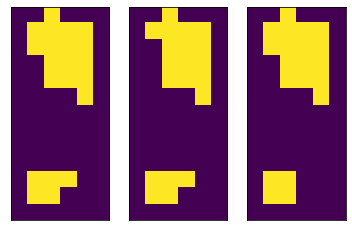

50_1_32_481901558001_2019-04-30 10_24_11-lv1-53781-36766-3290-3779


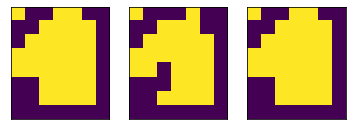

50_2_37_4018-16638A_2019-05-08 02_54_25-lv1-18037-16370-3576-4362


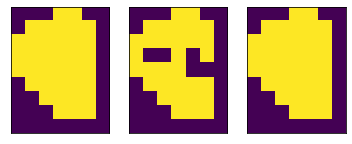

50_3_36_2918-13575A_2019-05-08 01_48_09-lv1-24486-16942-4263-6628


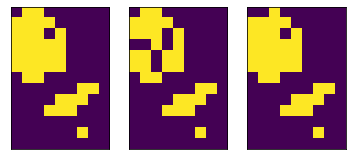

50_4_26_441900838001_2019-04-30 10_15_23-lv1-17110-19166-3362-4373


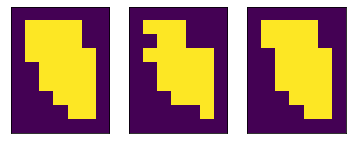

50_5_45_191901940-1_2019-04-30 10_30_47-lv1-40561-17303-4906-4343


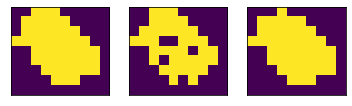

50_6_25_72018_68099_1-1_2019-02-20 23_21_13-lv1-18019-14672-3129-3364


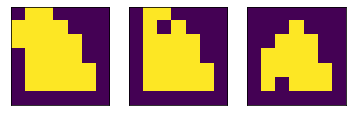

50_7_39_2118-15948A_2019-05-08 2_39_44-lv1-3890-15585-4835-3398


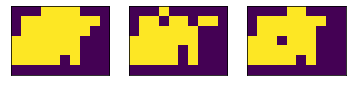

50_8_34_322018_67378_1-1_2019-02-20 22_49_25-lv1-43770-16472-3600-3412


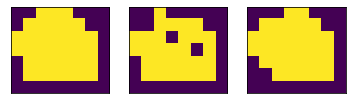

50_9_24_281800127001_2019-04-30 10_40_02-lv1-7573-15422-4121-2549


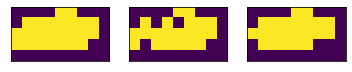

50_10_88_271900838001_2019-04-30 10_15_23-lv1-20231-15672-6703-7495


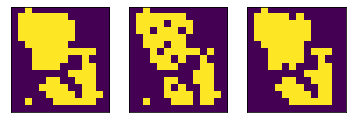

50_11_36_52018_67378_1-1_2019-02-20 22_49_25-lv1-40593-13366-3070-4835


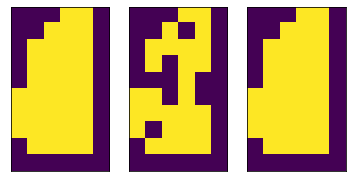

50_12_58_2618-16638B_2019-05-08 02_58_19-lv1-2771-11260-4929-4633


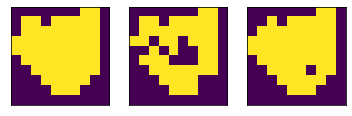

50_13_65_3918-13347A_2019-05-08 01_31_58-lv1-19772-17132-3435-7294


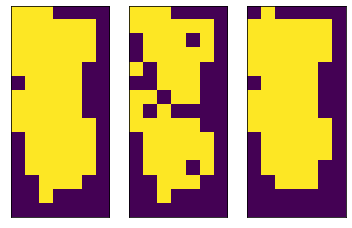

50_14_58_311901558001_2019-04-30 10_24_11-lv1-50393-31270-4213-7808


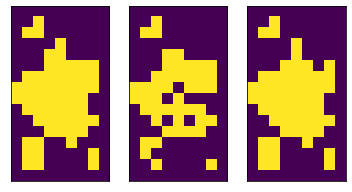

50_15_31_41800883002_2019-04-30 09_57_31-lv1-32373-29627-2888-5031


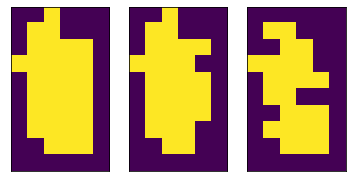

50_16_39_171901940-1_2019-04-30 10_30_47-lv1-44085-11603-3541-4701


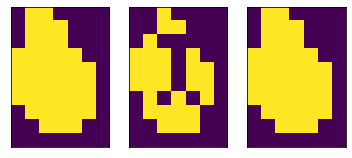

50_17_77_22018_70770_1-1_2019-02-20 23_53_21-lv1-32477-7770-6225-5402


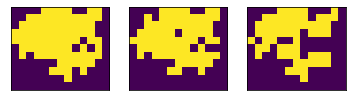

50_18_48_412018_70917_1-1_2019-02-20 23_55_17-lv1-43711-23484-4047-4165


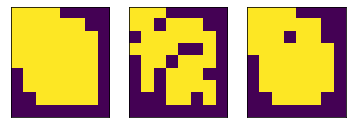

50_19_34_451901558001_2019-04-30 10_24_11-lv1-54922-32041-3594-3236


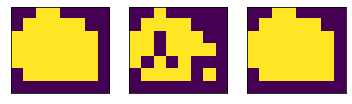

50_20_46_3518-16638B_2019-05-08 02_58_19-lv1-566-16540-4876-3615


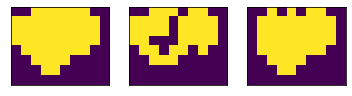

50_21_62_222018_62532_1-1_2019-02-20 21_54_51-lv1-53445-28477-5625-5981


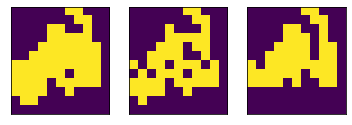

50_22_52_12018_70917_1-1_2019-02-20 23_55_17-lv1-40720-18654-3821-5317


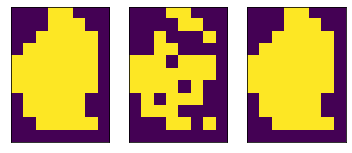

50_23_42_142018_67378_1-1_2019-02-20 22_49_25-lv1-41264-9330-5423-3812


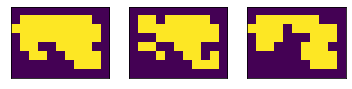

50_24_47_4318-14278A_2019-05-08 02_07_39-lv1-8938-10396-3934-5758


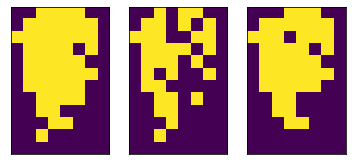

50_25_120_818-16638A_2019-05-08 02_54_25-lv1-21673-13678-6288-8686


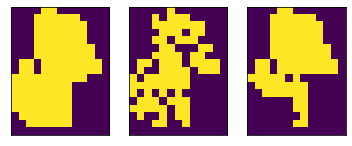

50_26_15_361800127001_2019-04-30 10_40_02-lv1-4386-16301-2230-4582


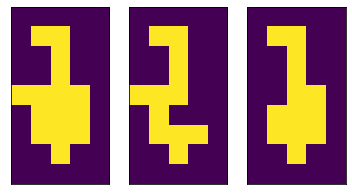

50_27_134_3818-13575B_2019-05-08 01_53_27-lv1-15618-6850-9892-9644


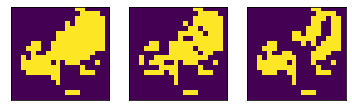

50_28_37_241800127001_2019-04-30 10_40_02-lv1-6892-18147-4571-3989


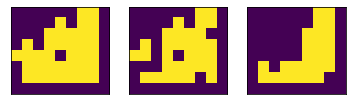

50_29_18_131901067001_2019-04-30 10_36_04-lv1-20509-14477-2904-3369


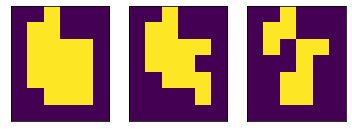

50_30_28_152018_70770_1-1_2019-02-20 23_53_21-lv1-39165-4987-3338-4289


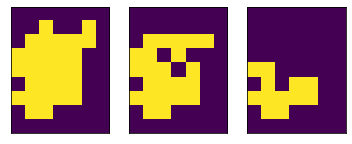

50_31_40_3318-14278B_2019-05-08 02_13_11-lv1-13964-11229-3779-5973


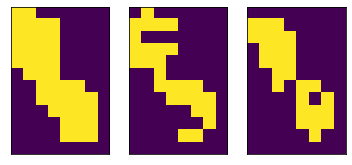

50_32_15_461800883002_2019-04-30 09_57_31-lv1-28885-30819-3472-3263


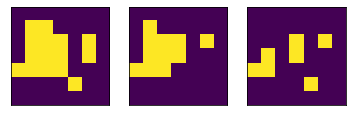

50_33_164_1618-13347B_2019-05-08 01_37_25-lv1-18918-18855-10791-8621


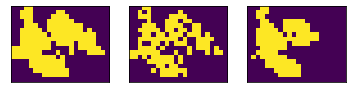

50_34_58_31900838001_2019-04-30 10_15_23-lv1-19388-22559-5824-4187


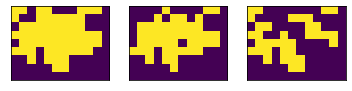

50_35_57_472018_70770_1-1_2019-02-20 23_53_21-lv1-31445-3075-5089-5065


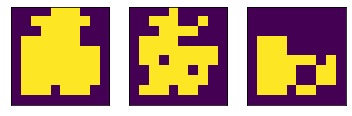

50_36_51_4218_00991B_2019-05-07 21_27_54-lv1-16174-30030-3538-5736


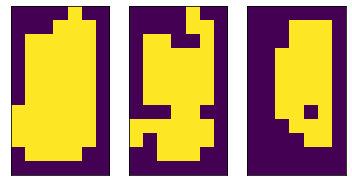

50_37_33_372018_67378_1-1_2019-02-20 22_49_25-lv1-46888-12754-2988-4306


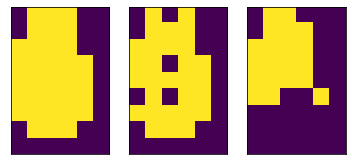

50_38_56_1218_00991B_2019-05-07 21_27_54-lv1-21230-29833-4835-6374


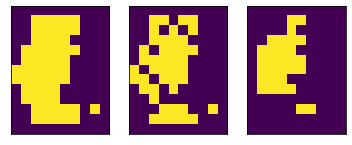

50_39_34_1118-15948A_2019-05-08 2_39_44-lv1-1998-10776-6940-4790


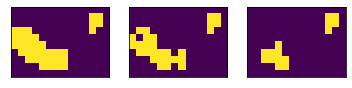

50_40_43_231901067001_2019-04-30 10_36_04-lv1-17809-14080-2848-6199


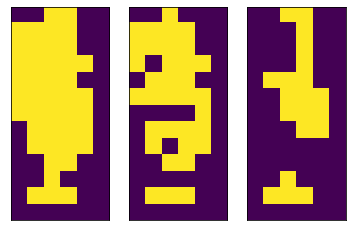

50_41_92_2518-13347A_2019-05-08 01_31_58-lv1-14057-17758-5693-6244


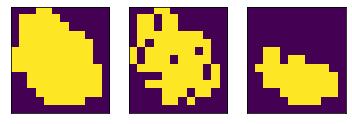

50_42_15_3018-13575A_2019-05-08 01_48_09-lv1-17672-19213-3072-3239


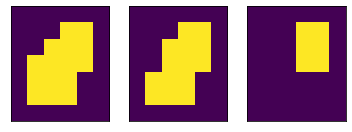

50_43_54_92018_62532_1-1_2019-02-20 21_54_51-lv1-48484-29236-5435-5412


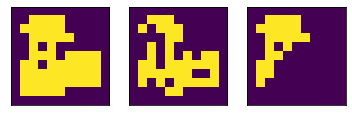

50_44_100_102018_68099_1-1_2019-02-20 23_21_13-lv1-12019-11071-5953-7294


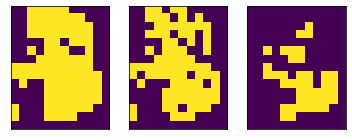

50_45_45_341800127001_2019-04-30 10_40_02-lv1-6628-22213-4692-4725


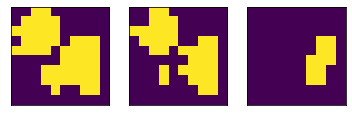

50_46_58_202018_68099_1-1_2019-02-20 23_21_13-lv1-7948-15919-4988-5294


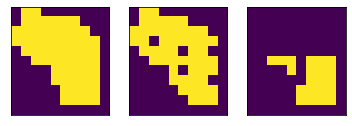

50_47_58_1818-14278B_2019-05-08 02_13_11-lv1-17874-10382-3996-6342


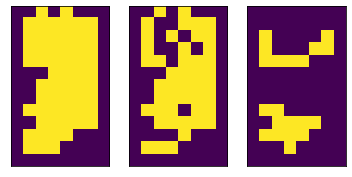

50_48_8_772019-06-04 18_19_44-lv1-18138-10941-1968-1560


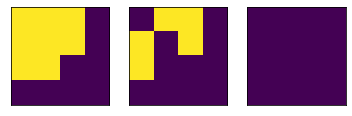

50_49_23_782019-06-10 22_26_06-lv1-12611-14863-3497-2931


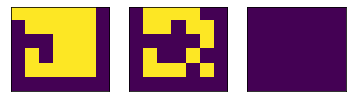

50_50_53_572019-06-10 22_50_47-lv1-16963-1271-5614-3990


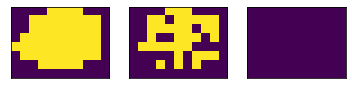

50_51_27_1142019-06-10 21_52_25-lv1-15458-1750-3237-3062


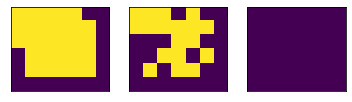

50_52_42_862019-06-10 21_56_49-lv1-25671-5757-4260-4260


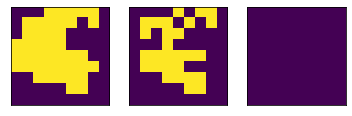

50_53_34_61800127001_2019-04-30 10_40_02-lv1-1001-22444-3989-3967


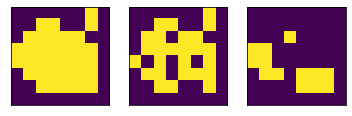

50_54_84_1192019-06-10 14_17_59-lv1-30053-13982-7405-5582


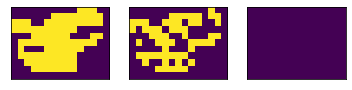

50_55_54_01901940-1_2019-04-30 10_30_47-lv1-39947-11074-3848-5785


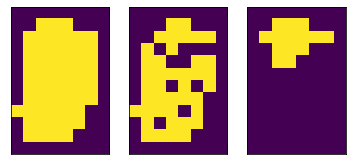

50_56_46_912019-06-10 22_57_15-lv1-19978-7881-5271-3497


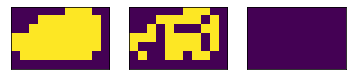

50_57_60_1002019-06-10 12_02_57-lv1-32324-14737-5010-5710


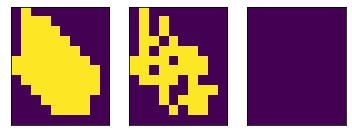

50_58_53_1132019-06-10 22_53_48-lv1-13566-16159-4725-4900


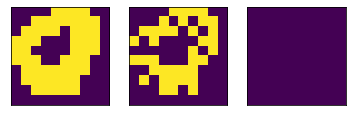

50_59_32_712019-06-10 23_20_12-lv1-21385-4974-3108-4290


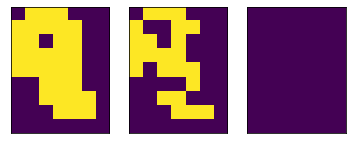

50_60_18_1042019-06-10 21_33_44-lv1-17722-21202-2673-2735


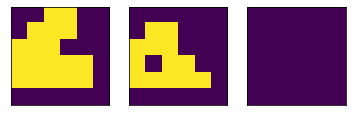

50_61_36_1232019-06-10 23_25_16-lv1-17265-14669-3223-4835


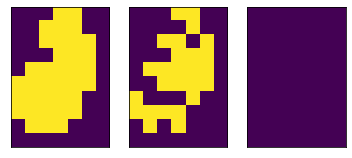

50_62_29_1082019-06-10 13_44_16-lv1-1845-11483-3788-4007


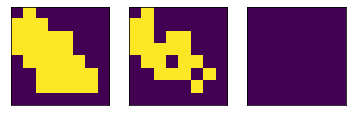

50_63_49_1052019-06-10 23_01_17-lv1-15671-13172-3951-5388


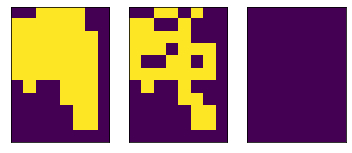

50_64_27_932019-06-10 13_05_20-lv1-16334-16650-3601-3285


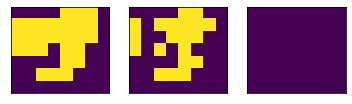

50_65_31_672019-06-10 21_03_27-lv1-3469-15205-2943-4251


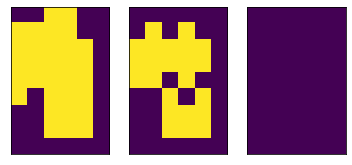

50_66_153_882019-06-10 22_56_10-lv1-747-14359-8009-8045


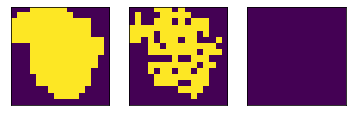

50_67_37_602019-06-10 21_26_57-lv1-601-13179-4110-3458


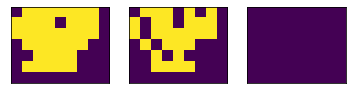

50_68_37_532019-06-10 21_56_49-lv1-1146-10996-4605-4029


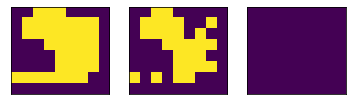

50_69_29_662019-06-10 23_12_06-lv1-29612-14068-3638-3032


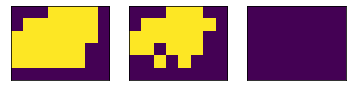

50_70_55_1222019-06-10 22_46_35-lv1-32043-6211-5637-4958


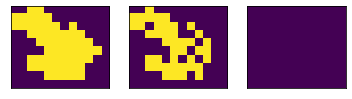

50_71_51_732019-06-10 22_40_10-lv1-2678-16703-4958-4958


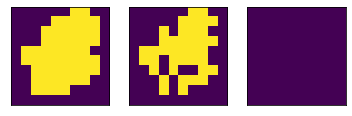

50_72_43_922019-06-10 23_16_07-lv1-1304-11584-4669-3073


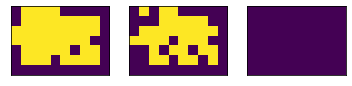

50_73_43_502019-06-10 23_27_48-lv1-16624-8122-4998-3181


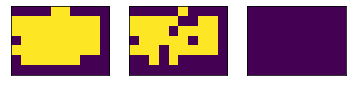

50_74_13_1152019-06-10 22_36_47-lv1-26860-18177-2272-2215


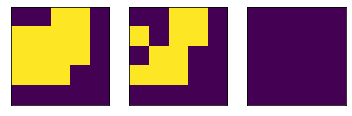

50_75_88_872019-06-10 11_34_05-lv1-15856-26436-6294-5706


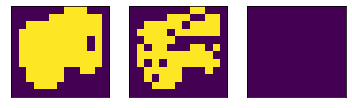

50_76_49_972019-06-10 22_40_10-lv1-16406-15189-4750-4593


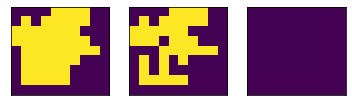

50_77_122_1172019-06-10 22_42_40-lv1-24369-15290-7307-5711


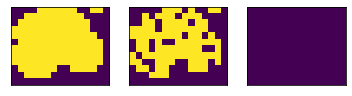

50_78_122_812019-06-10 21_25_25-lv1-3163-15541-9072-4719


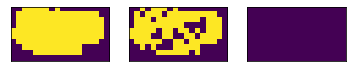

50_79_32_682019-06-10 11_22_45-lv1-31445-5428-3392-3914


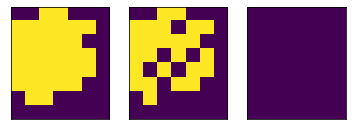

50_80_46_552019-06-10 23_09_09-lv1-19684-2487-4605-3684


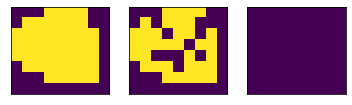

50_81_23_1102019-06-10 11_04_00-lv1-17543-31398-3874-3223


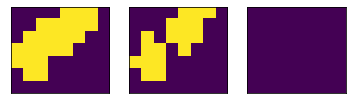

50_82_69_642019-06-10 22_28_55-lv1-13038-20698-5105-4669


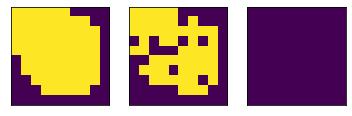

50_83_71_1312019-06-04 18_19_44-lv1-5723-9984-5601-5270


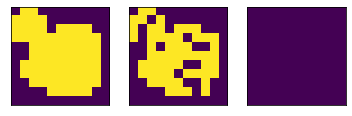

50_84_76_1022019-06-10 21_21_25-lv1-16596-12509-7415-4191


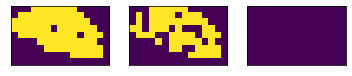

50_85_38_1202019-06-10 21_33_44-lv1-2551-18715-3544-3606


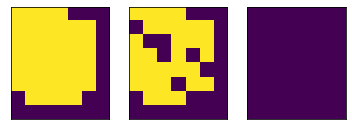

50_86_19_762019-06-10 21_49_43-lv1-21091-6948-3426-2284


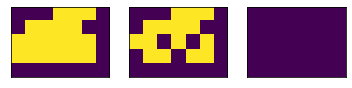

50_87_43_802019-06-10 12_32_46-lv1-16547-15918-4321-3621


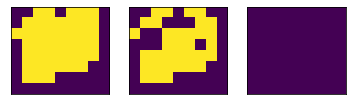

50_88_63_1112019-06-10 22_00_27-lv1-18950-13258-4802-4750


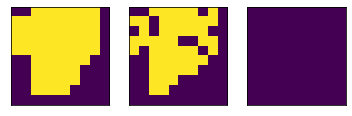

50_89_68_652019-06-10 12_36_51-lv1-14783-14099-5895-4224


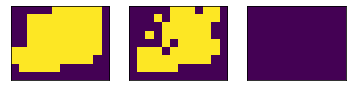

50_90_49_1272019-06-10 21_06_06-lv1-18277-1317-3632-5069


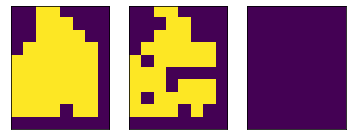

50_91_84_1282019-06-10 14_17_59-lv1-14799-13043-6355-6908


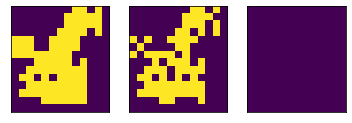

50_92_50_1092019-06-10 21_17_55-lv1-21656-14968-3626-4835


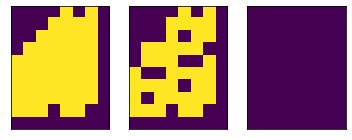

50_93_61_1062019-06-10 22_19_26-lv1-734-13605-6254-4191


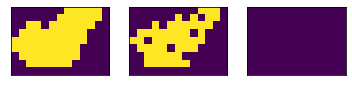

50_94_67_562019-06-10 21_36_55-lv1-20465-12834-5158-5342


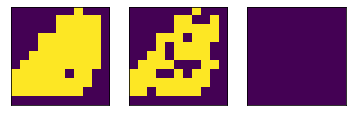

50_95_62_742019-06-10 22_19_26-lv1-24591-12638-6061-4320


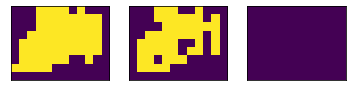

50_96_88_1252019-06-10 22_03_21-lv1-1471-12813-6705-5867


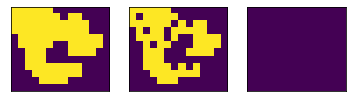

50_97_84_1302019-06-10 23_05_58-lv1-17691-13669-5093-7479


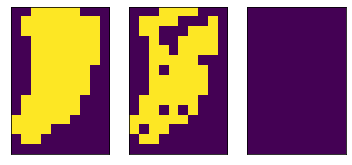

50_98_32_1122019-06-10 23_12_06-lv1-625-22558-3517-3274


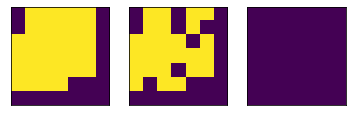

50_99_91_992019-06-10 21_11_51-lv1-8969-8290-5968-6687


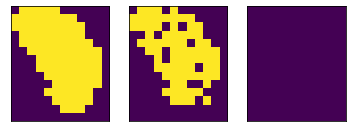

50_100_59_902019-06-10 22_36_47-lv1-21862-15109-4714-5339


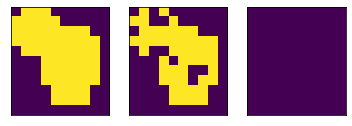

50_101_113_1262019-06-10 22_42_40-lv1-17982-13510-6140-6693


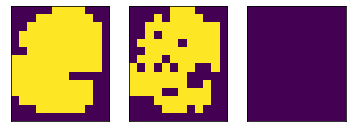

50_102_77_752019-06-10 21_46_37-lv1-1963-11036-5760-5033


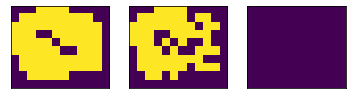

50_103_33_822019-06-10 22_07_12-lv1-18929-19358-3368-3975


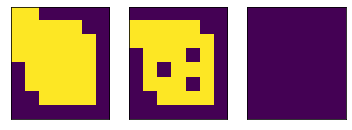

50_104_95_1292019-06-10 22_33_32-lv1-3502-12162-8299-5376


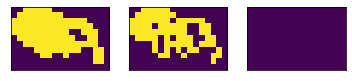

50_105_90_792019-06-10 21_11_51-lv1-16817-3426-6576-6024


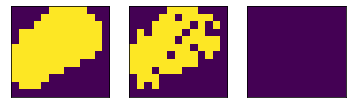

50_106_86_852019-06-10 21_41_32-lv1-28368-16176-7679-4154


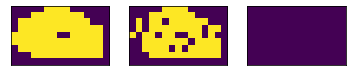

50_107_46_632019-06-10 21_54_03-lv1-1377-7630-4352-4029


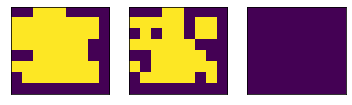

50_108_23_1162019-06-10 13_44_16-lv1-15065-13356-3316-3362


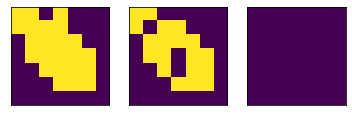

50_109_140_1072019-06-10 12_45_24-lv1-14780-12159-9189-6892


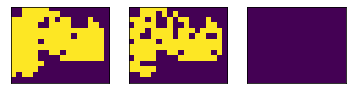

50_110_66_842019-06-10 22_23_19-lv1-16965-13540-6383-3965


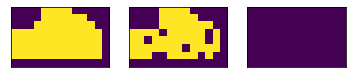

50_111_49_1242019-06-10 22_13_56-lv1-17041-12331-4567-4502


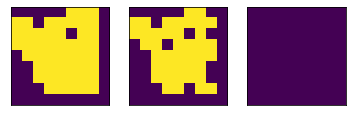

50_112_37_1212019-06-10 11_34_05-lv1-13604-36857-3706-3776


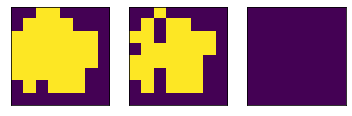

50_113_132_1032019-06-10 21_25_25-lv1-722-20382-9031-4759


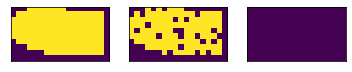

50_114_45_592019-06-10 22_53_48-lv1-1899-20010-4842-4492


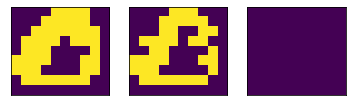

50_115_26_942019-06-10 21_03_27-lv1-17203-4033-3433-4087


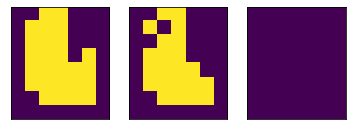

50_116_27_582019-06-10 23_16_07-lv1-27607-18086-3487-2659


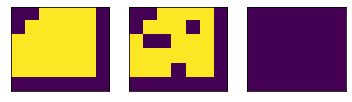

50_117_75_982019-06-10 21_41_32-lv1-26668-22534-8056-3650


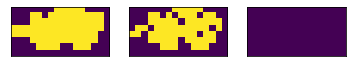

50_118_48_692019-06-10 21_31_01-lv1-16233-13117-5404-5600


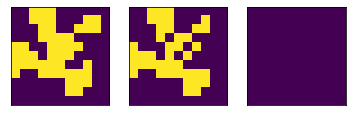

50_119_74_612019-06-10 21_36_55-lv1-26790-10316-4912-5895


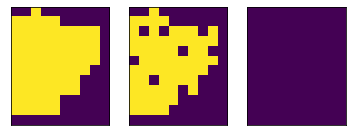

50_120_89_542019-06-10 22_03_21-lv1-25780-18860-6586-6346


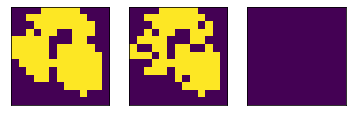

50_121_45_1182019-06-10 21_54_03-lv1-17389-15099-4083-3976


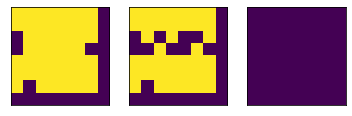

50_122_39_702019-06-10 21_26_57-lv1-25069-12070-4045-3719


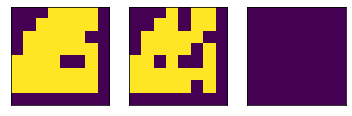

50_123_17_622019-06-10 23_30_43-lv1-11782-4495-2434-2996


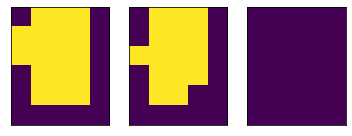

50_124_43_892019-06-10 13_05_20-lv1-17842-13598-5179-3110


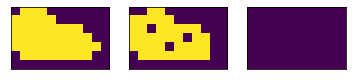

50_125_38_1012019-06-10 22_10_29-lv1-19231-10197-4469-3147


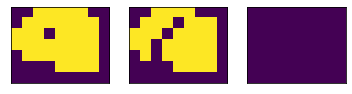

50_126_49_722019-06-10 21_06_06-lv1-28535-558-3792-5628


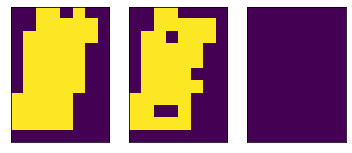

50_127_20_832019-06-10 22_26_06-lv1-15337-8125-3034-2931


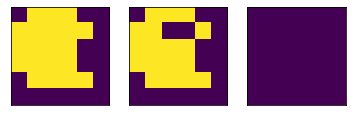

50_128_11_962019-06-10 11_04_00-lv1-3594-33188-2861-1661


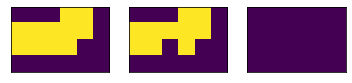

50_129_15_952019-06-10 12_32_46-lv1-15594-13858-2687-2104


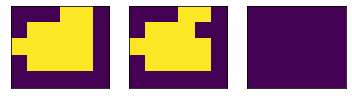

50_130_6_522019-06-10 11_04_00-lv1-2580-34878-1335-1611


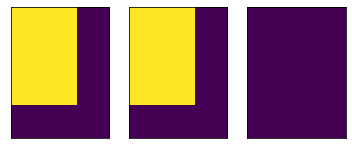

50_131_14_512019-06-10 21_17_55-lv1-528-19804-1784-2993


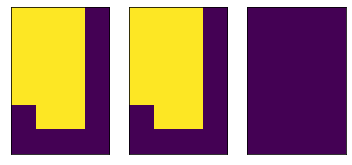

In [63]:
trainset=configs.valset
preds_tensor = torch.cat(preds_list)
bag_index_tensor = torch.cat(bag_index_list)
labels_tensor = torch.cat(label_list)
bag_pos_ratio = torch.stack(trainset.bag_pos_ratios)

##CAlibration
for i in range(bag_index_tensor.max() + 1):
    preds_tensor[bag_index_tensor==i] = (preds_tensor[bag_index_tensor==i]/(preds_tensor[bag_index_tensor==i].mean()))




rank_tensor = torch.topk(preds_tensor.squeeze(-1), len(preds_tensor))[1]
idx_x_tensor = torch.cat(idx_x_list)
idx_y_tensor = torch.cat(idx_y_list)
#  f0,40 f1,35, f2 30%,f3:45%, f4 40
ratio = 0.2
binary_mask_tensor = (rank_tensor > ratio * len(rank_tensor)).float().cpu()
# selection based on ca
bag_selection_in_list = [binary_mask_tensor[bag_index_tensor == i] for i in range(bag_index_tensor.max() + 1) if
                         torch.stack(trainset.bag_pos_ratios)[i] != 0]
# real labels
bag_labels_in_list = [labels_tensor[bag_index_tensor == i] for i in range(bag_index_tensor.max() + 1) if
                      torch.stack(trainset.bag_pos_ratios)[i] != 0]

path_in_list = [np.array(path_list)[bag_index_tensor == i] for i in range(bag_index_tensor.max() + 1) if
                torch.stack(trainset.bag_pos_ratios)[i] != 0]
# selection == real label
selection_acc_in_list = [
    (bag_selection_in_list[i] == bag_labels_in_list[i]).sum().float() / len(bag_selection_in_list[i]) for i in
    range(len(bag_selection_in_list))]
idx_xs = [idx_x_tensor[bag_index_tensor == i] for i in range(bag_index_tensor.max() + 1) if
          torch.stack(trainset.bag_pos_ratios)[i] != 0]
idx_ys = [idx_y_tensor[bag_index_tensor == i] for i in range(bag_index_tensor.max() + 1) if
          torch.stack(trainset.bag_pos_ratios)[i] != 0]
values, indices = torch.topk(torch.stack(selection_acc_in_list), len(selection_acc_in_list))
print(values)
for i in range(len(indices)): #len(indices)
    chosen_idx = indices[i].item()
    bag_len = len(bag_labels_in_list[chosen_idx])
    one_path =  path_in_list[chosen_idx][0].split('/')[-2]
    # chosen by selection
    chosen_x = idx_xs[chosen_idx][bag_selection_in_list[chosen_idx]==1]
    chosen_y = idx_ys[chosen_idx][bag_selection_in_list[chosen_idx]==1]
    # chosen by real label
    real_x = idx_xs[chosen_idx][bag_labels_in_list[chosen_idx]==1]
    real_y = idx_ys[chosen_idx][bag_labels_in_list[chosen_idx]==1]
    # A is ca & selection
    tmp = np.zeros((idx_xs[chosen_idx].max()+2,idx_ys[chosen_idx].max()+2))
    tmp[chosen_x,chosen_y]=1
    from PIL import Image
    import matplotlib.pyplot as plt
    A= Image.fromarray(np.uint8(tmp)*255)
    # B is real 
    tmp = np.zeros((idx_xs[chosen_idx].max()+2,idx_ys[chosen_idx].max()+2))
    tmp[real_x,real_y ]=1
    B= Image.fromarray(np.uint8(tmp)*255)
    # C is simplemil
    tmp = np.zeros((idx_xs[chosen_idx].max()+2,idx_ys[chosen_idx].max()+2))
    tmp[idx_xs[chosen_idx],idx_ys[chosen_idx] ]=1
    C= Image.fromarray(np.uint8(tmp)*255)
    img_list = [C, A, B]
    plt.figure()
    import os 
    if not os.path.exists(os.path.join(trainer.logger.logdir, 'pred_figs',str(epoch))):
            os.makedirs(os.path.join(trainer.logger.logdir, 'pred_figs',str(epoch)))
    for j in range(1,4):
        plt.subplot(1,3,j)
        plt.imshow(img_list[j-1])
        plt.xticks([])
        plt.yticks([])
#         plt.savefig(os.path.join(trainer.logger.logdir, 'pred_figs',str(epoch) , "{}.png".format(str(epoch)+'_'+str(i)+'_'+str(bag_len)+'_'+str(chosen_idx)+one_path)))
    print('{}'.format((str(epoch)+'_'+str(i)+'_'+str(bag_len)+'_'+str(chosen_idx)+one_path)))
    plt.show() # real vs learned, name:epoch+rank+bag_len+bag_num

In [6]:
len(binary_mask_tensor)

35187

50_0_14_26D201803519_2019-05-14 15_14_44-lv1-33951-36629-2732-1964


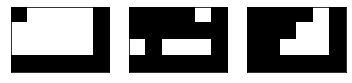

50_1_23_14518-10829B_2019-05-08 00_47_24-lv1-20240-15499-4901-5215


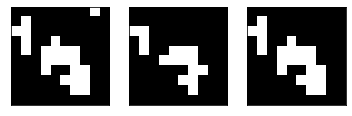

50_2_31_9118-01592A_2019-05-07 21_59_18-lv1-18492-12001-4720-3984


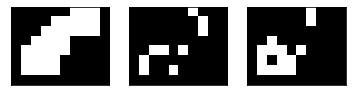

50_3_56_7618-01080B_2019-05-07 21_33_52-lv1-15262-19621-5715-4803


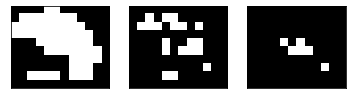

50_4_117_151D201802733_2019-05-14 15_41_01-lv1-18828-14936-7756-5310


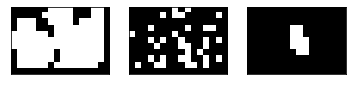

50_5_28_124D201803519_2019-05-14 15_14_44-lv1-38218-28839-3928-3522


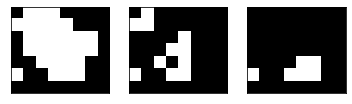

50_6_49_16D201803519_2019-05-14 15_14_44-lv1-37789-37126-5701-3477


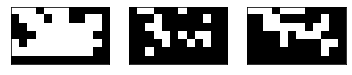

50_7_1172_62D201707227_2019-05-14 13_49_08-lv1-535-16796-26010-19568


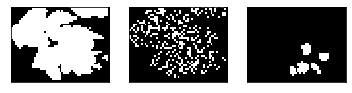

50_8_61_3418-03912B_2019-05-07 23_00_51-lv1-27843-12739-3728-6223


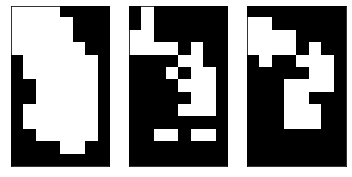

50_9_618_56D20170758903_2019-05-14 13_53_08-lv1-21036-0-13452-15494


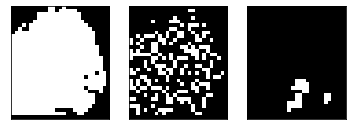

50_10_60_169D201710920_2019-05-21 11_52_57-lv1-33534-26482-6376-4721


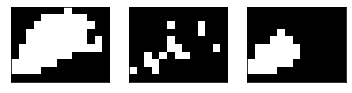

50_11_51_18418-03912A_2019-05-07 22_55_07-lv1-16713-11566-3121-5791


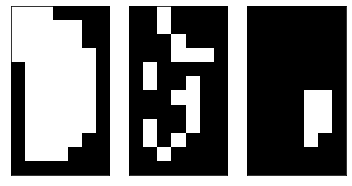

50_12_39_99D201803511_2019-05-14 15_24_16-lv1-35489-31012-3664-4696


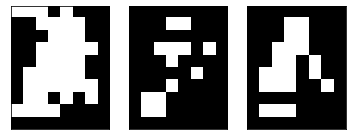

50_13_1064_144D20170758903_2019-05-14 13_53_08-lv1-416-0-20070-19374


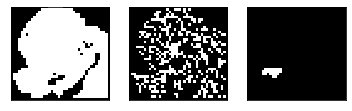

50_14_8_7418-03912A_2019-05-07 22_55_07-lv1-13993-9429-2461-4154


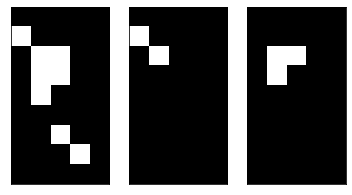

50_15_529_18D201707788_2019-05-14 14_05_34-lv1-989-2393-13582-13495


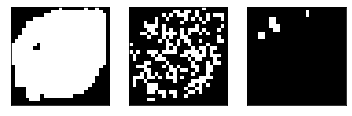

50_16_589_80D20170584502_2019-05-14 12_43_57-lv1-863-489-13565-15647


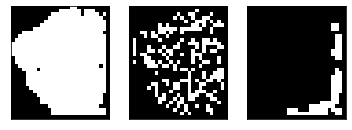

50_17_339_108D20181010201_2019-05-21 14_08_09-lv1-57001-816-15224-14673


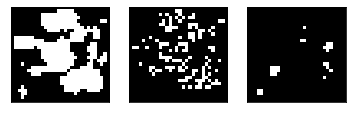

50_18_87_1032019_05944_1-1_2019-02-20 20_42_06-lv1-31069-20357-7018-5934


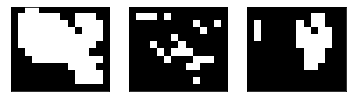

50_19_32_192019_07896_1-1_2019-02-20 21_18_02-lv1-8871-6172-4468-2821


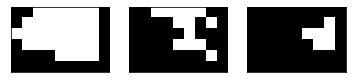

In [5]:
for i in range(20): #len(indices)
    chosen_idx = indices[i].item()
    bag_len = len(bag_labels_in_list[chosen_idx])
#     print('baglen',len(bag_labels_in_list[chosen_idx]))
    one_path =  path_in_list[chosen_idx][0].split('/')[-2]
#     print(one_path, path_in_list[chosen_idx][0])
#     break
    chosen_x = idx_xs[chosen_idx][bag_selection_in_list[chosen_idx]==1]
    chosen_y = idx_ys[chosen_idx][bag_selection_in_list[chosen_idx]==1]
    real_x = idx_xs[chosen_idx][bag_labels_in_list[chosen_idx]==1]
    real_y = idx_ys[chosen_idx][bag_labels_in_list[chosen_idx]==1]
    # chosen_x ,chosen_y, real_x, real_y
    tmp = np.zeros((idx_xs[chosen_idx].max()+2,idx_ys[chosen_idx].max()+2))
    tmp[chosen_x,chosen_y]=1
    from PIL import Image
    import matplotlib.pyplot as plt
    A= Image.fromarray(np.uint8(tmp)*255)
    tmp = np.zeros((idx_xs[chosen_idx].max()+2,idx_ys[chosen_idx].max()+2))
    tmp[real_x,real_y ]=1
    B= Image.fromarray(np.uint8(tmp)*255)
    tmp = np.zeros((idx_xs[chosen_idx].max()+2,idx_ys[chosen_idx].max()+2))
    tmp[idx_xs[chosen_idx],idx_ys[chosen_idx] ]=1
    C= Image.fromarray(np.uint8(tmp)*255)
    img_list = [C, A, B]
    plt.figure()
    import os 
    if not os.path.exists(os.path.join(trainer.logger.logdir, 'pred_figs',str(epoch))):
            os.makedirs(os.path.join(trainer.logger.logdir, 'pred_figs',str(epoch)))
    for j in range(1,4):
        plt.subplot(1,3,j)
        plt.imshow(img_list[j-1], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.savefig(os.path.join(trainer.logger.logdir, 'pred_figs',str(epoch) , "{}.png".format(str(epoch)+'_'+str(i)+'_'+str(bag_len)+'_'+str(chosen_idx)+one_path)))
    print('{}'.format((str(epoch)+'_'+str(i)+'_'+str(bag_len)+'_'+str(chosen_idx)+one_path)))
    plt.show() # real vs learned, name:epoch+rank+bag_len+bag_num